# Lateral ventricle volume trajectories and response inhibition

Notebook (using both Python and R [rpy2]) accompanying the manuscript:

*Astri J. Lundervold, Alexandra Vik, Arvid Lundervold* <br>
**Lateral ventricle volume trajectories predict response inhibition in older age - a
longitudinal brain imaging and machine learning approach** <br>



Arvid Lundervold, ver. 20190116


*Objective:* In a three-wave 6 yrs longitudinal study we investigated if expansion of
lateral ventricle (LV) volumes (regarded as a proxy for brain parenchyma loss) predicts
performance on a test of response inhibition. *Participants and Methods:* Anatomical
trajectories of left (LH) and right (RH) lateral ventricle volumes across the three
study-waves were quantified using the Longitudinal Stream in Freesurfer 5.3 and
modelled using a linear mixed-effects (LME) algorithm. All participants (N = 74, mean
age 60.7 yrs at inclusion, 48 females) performed the Color-Word Interference Test
(CWIT). Response time on the third condition was used as a measure of response
inhibition (RI) and divided into three classes (fast, medium and slow). The Extreme
Gradient Boosting (XGBoost) algorithm was used for calculating the relative
importance of selected LV volume features from the LME model in predicting RI class.
Finally, the two most important extracted features were fed into a 10-fold
cross-validation framework, estimating the accuracy, precision and recall of the RI
class prediction. *Results:* Four LME based features were selected to characterize LV volume
trajectories: steepness of LV volume change and the LV volume at the time of
inclusion, each from the right and left hemisphere. The XGBoost procedure selected the
steepness measure from the right and the volume at inclusion from the left hemisphere as the two
most important features to predict RI performance. The 10-fold cross validation
procedure showed a recall, precision and accuracy score (.40 - .50) that were clearly
above chance level. *Conclusion:* Measures of the LV volume trajectories gave a fairly
good prediction of response inhibition performance, confirming the role of LV volume
as a biomarker of cognitive function in older adults. Future studies should investigate the
value of the lateral ventricle volume trajectories as predictors of cognitive preservation
or decline into older age.

The linear mixed effect model (LME) was fitted to the data, i.e.

$$\text{Vol}_{ij} = \beta_0 + \beta_1 \text{Age}_{ij} + (b_{0i} + b_{1i} \text{Age}_{ij}) + \epsilon_{ij}$$

Here, $\text{Vol}_{ij}$ the continuous *response variable* in the model is volume of left (right) latreral ventricle in subject $i$ ($i=1,\ldots,N$) at wave $j$ ($j=1,\ldots,n_i$). In our case we have $N=74$ and three wase with complete data, i.e. $n_i=3$ for all $i$. $\text{Age}_{ij}$ is age (in years) of subject $j$ at wave $j$, and a *predictor variable* in the model.

The model parameterrs $\beta_0$ and $\beta_1$ are *fixed effects* parameters.  The variables $b_{0i}$ and $b_{1i}$ 
($i=1,\ldots,N$) are the *random effects* parameters, assumed to be normally distributed witrh zero mean. They denote individual deviations in intercept ($b_{0i}$) and slope ($b_{1i}$), respectiveley, from the group-level fixed effect.
Finally, the random residual errors $\epsilon_{ij}$ are assumed to be independent and normally distributed (i.i.d) with zero mean and constant variance $\sigma_\epsilon^2$.

## Prepare

**Data being used** is obtained from the original data processed
```python
# where we do:
# df_long.to_csv('../data/XXX_XXXXXX_Long_74x411.csv', index=False)
X_data = '../data/XXX_XXXXXX_Long_74x411.csv'
dfX= pd.read_csv(X_data)
my_cols = ['Subject', 'Sex', 
           'AcquisitionYearsW1', 'AcquisitionYearsW2',
           'AcquisitionYearsW3',
          'Left-Lateral-Ventricle_W1','Left-Lateral-Ventricle_W2',
           'Left-Lateral-Ventricle_W3',
          'Right-Lateral-Ventricle_W1','Right-Lateral-Ventricle_W2',
           'Right-Lateral-Ventricle_W3',
          'Stroop_3_R_W3']
df_lvv_ri = dfX[my_cols]

# Make enumerated list of Subject ids:
k=0
for sub in df_lvv_ri['Subject']:
    k=k+1
    s = 'subj_%02d' % k
    df_lvv_ri.replace(sub,s,inplace=True)
df_lvv_ri.head()
# Save the data to the present repository as .csv
df_lvv_ri.to_csv('../data/lvv_ri_data.csv', header=True, index=False)
# and as .xlsx file
writer = pd.ExcelWriter('../data/lvv_ri_data.xlsx')
df_lvv_ri.to_excel(writer,'Sheet1',index=False)
writer.save()
```

### Packages and libraries

In [4]:
import os
import os.path as op
import sys
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import math
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
# XGboost Windows10:
# https://stackoverflow.com/questions/33749735/how-to-install-xgboost-package-in-python-windows-platform
# git clone --recursive https://github.com/dmlc/xgboost
# cd xgboost
# git submodule init
# git submodule update
# cp make/mingw64.mk config.mk
# make -j4
# ./build.sh
# cd python-package
# python setup.py install
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn import tree
import graphviz
from distutils.sysconfig import get_python_lib
import sklearn
import matplotlib
import xgboost as xgb
import rpy2
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()
from rpy2.robjects.lib.tidyr import DataFrame

# Enable inline plotting
%matplotlib inline

In [5]:
print('Python version ' + sys.version)
print(get_python_lib())
print('numpy: %s' % np.__version__)
print('pandas: %s' % pd.__version__)
print('scipy: %s' % scipy.__version__)
print('matplotlib: %s' % matplotlib.__version__)
print('sklearn: %s' % sklearn.__version__)
print('seaborn: %s' % sns.__version__)
print('xgboost: %s' % xgb.__version__)
print('graphviz: %s' % graphviz.__version__)
print('rpy2: %s' % rpy2.__version__)

Python version 3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)]
C:\Users\arvid\Anaconda3\Lib\site-packages
numpy: 1.14.5
pandas: 0.23.4
scipy: 1.1.0
matplotlib: 3.0.2
sklearn: 0.20.0
seaborn: 0.9.0
xgboost: 0.80
graphviz: 0.8.4
rpy2: 2.9.3


## Reading and exploring data

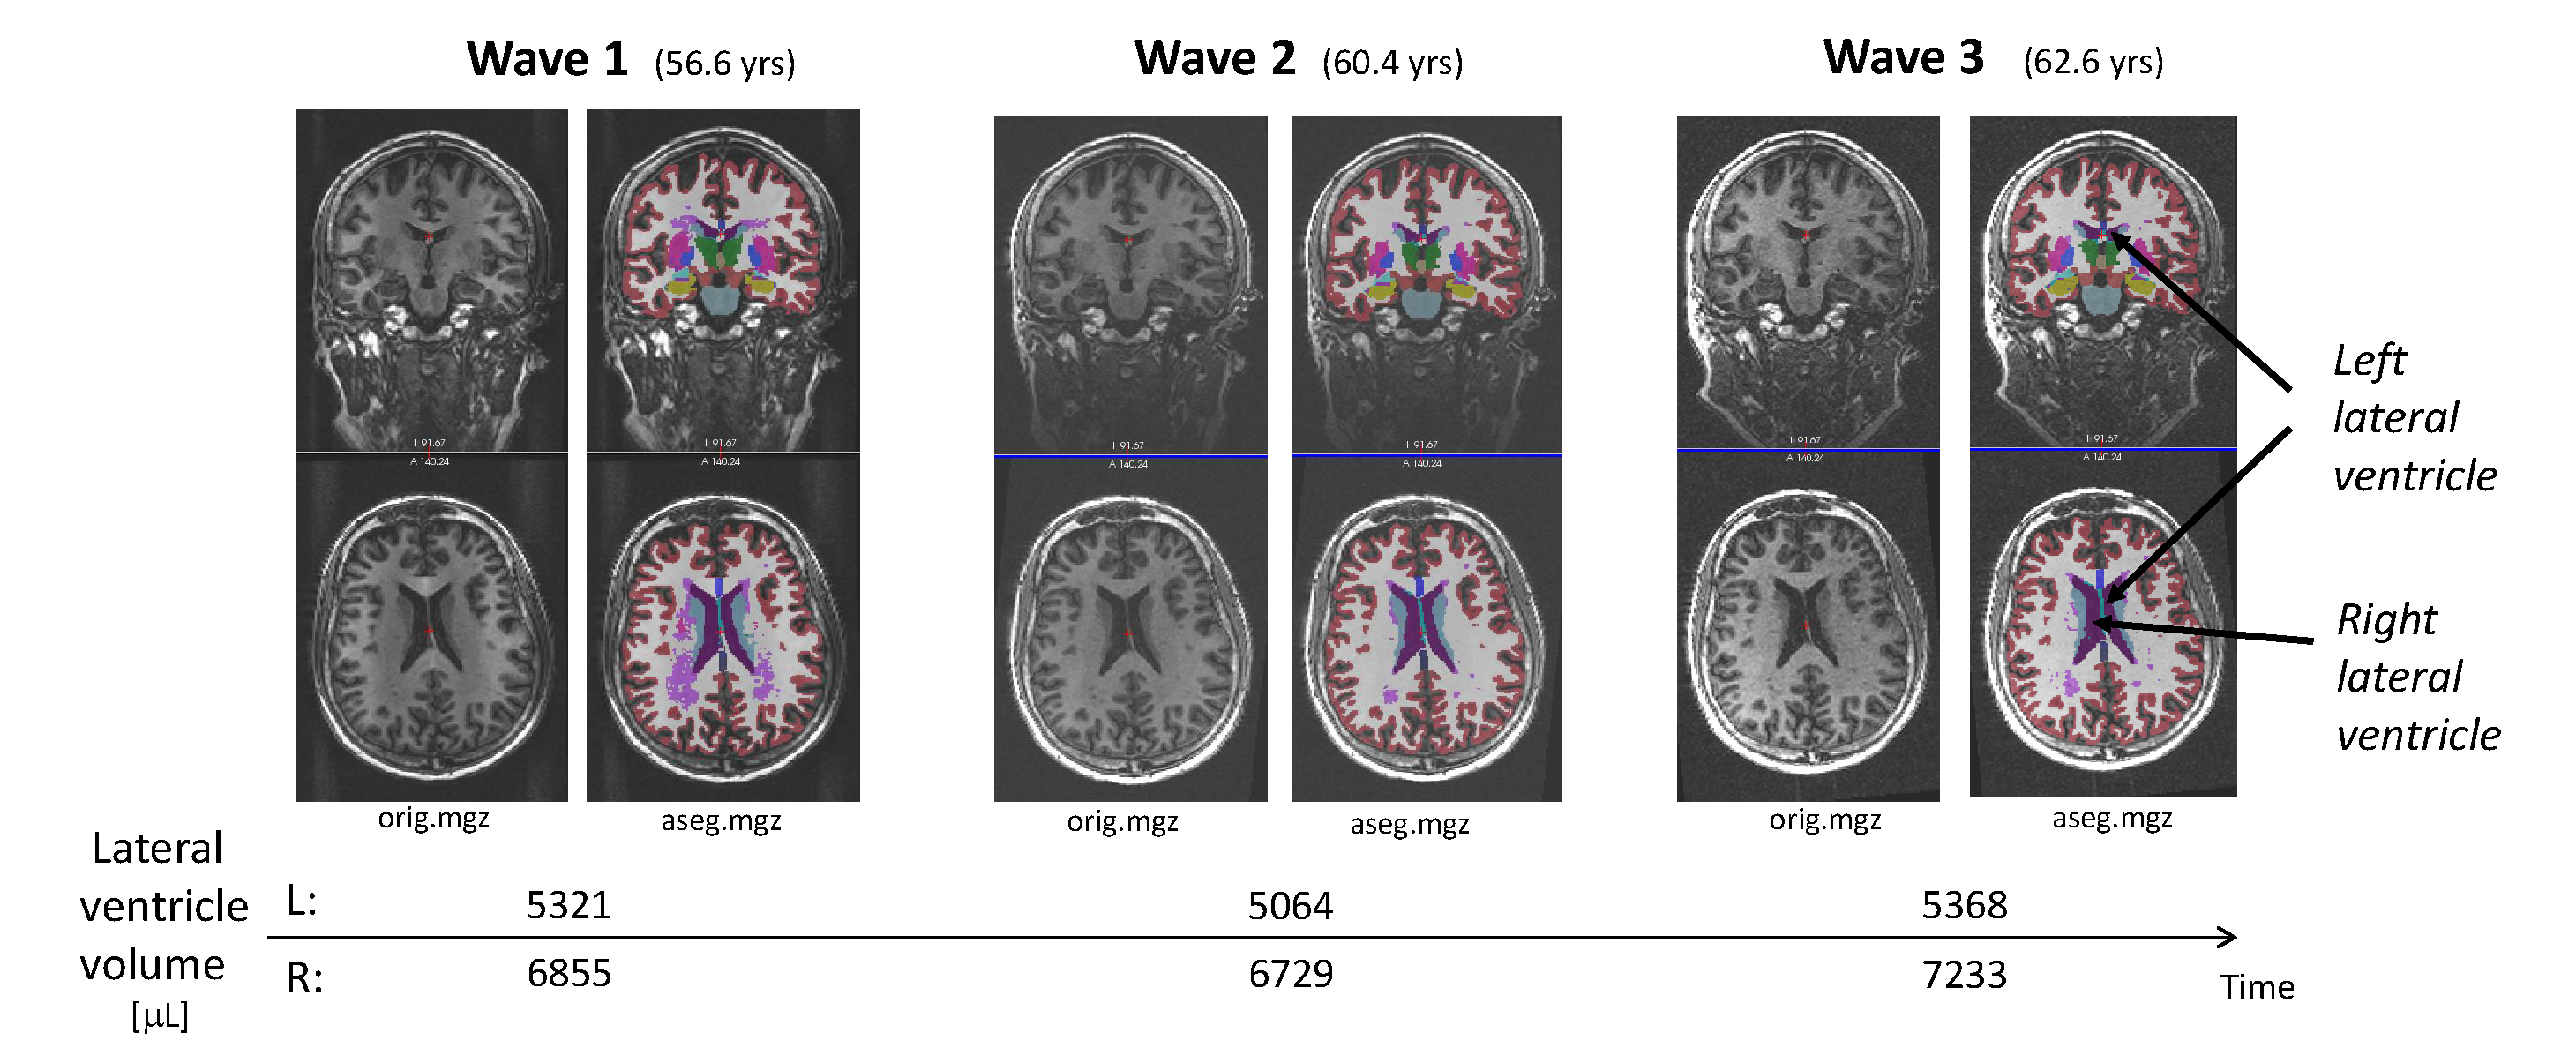

In [6]:
from IPython.display import Image
Image(filename='../images/Figure_1.png', width=800)

In [7]:
fn_data = '../data/lvv_ri_data.csv'
df = pd.read_csv(fn_data)

### Explore data

In [8]:
df.shape

(74, 12)

In [9]:
#for col in df.columns:
#    print(col)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 12 columns):
Subject                       74 non-null object
Sex                           74 non-null object
AcquisitionYearsW1            74 non-null float64
AcquisitionYearsW2            74 non-null float64
AcquisitionYearsW3            74 non-null float64
Left-Lateral-Ventricle_W1     74 non-null float64
Left-Lateral-Ventricle_W2     74 non-null float64
Left-Lateral-Ventricle_W3     74 non-null float64
Right-Lateral-Ventricle_W1    74 non-null float64
Right-Lateral-Ventricle_W2    74 non-null float64
Right-Lateral-Ventricle_W3    74 non-null float64
Stroop_3_R_W3                 74 non-null float64
dtypes: float64(10), object(2)
memory usage: 7.0+ KB


In [10]:
df.head(5).T

0        1        2        3        4
Subject                     subj_01  subj_02  subj_03  subj_04  subj_05
Sex                               F        M        M        M        M
AcquisitionYearsW1            56.63    49.07    74.61    56.23    63.22
AcquisitionYearsW2            60.35    52.58    78.14    59.78       67
AcquisitionYearsW3            62.62    55.05    80.59    62.68    69.53
Left-Lateral-Ventricle_W1    5321.4  11038.6  29718.4  21830.1  17205.1
Left-Lateral-Ventricle_W2    5063.6  11912.2  32265.1  23933.6  16970.1
Left-Lateral-Ventricle_W3    5368.3  12313.3    35887  26164.2  15858.1
Right-Lateral-Ventricle_W1   6855.2  10611.6    34241  15243.9  13962.1
Right-Lateral-Ventricle_W2   6729.2  11774.8  37155.2  16505.1  13755.5
Right-Lateral-Ventricle_W3   7233.2  12070.5  41221.4  18509.1  13143.9
Stroop_3_R_W3                    66       85       71       41       62

In [11]:
df.describe(percentiles = [.5]).T.round(2)

count      mean       std      min       50%  \
AcquisitionYearsW1           74.0     60.75      7.25    46.66     59.88   
AcquisitionYearsW2           74.0     64.28      7.21    50.11     63.56   
AcquisitionYearsW3           74.0     66.81      7.19    52.46     66.02   
Left-Lateral-Ventricle_W1    74.0  14994.10   8584.68  5303.10  12259.60   
Left-Lateral-Ventricle_W2    74.0  16450.17   9589.52  5063.60  13288.65   
Left-Lateral-Ventricle_W3    74.0  17605.22  10354.05  5235.00  14225.50   
Right-Lateral-Ventricle_W1   74.0  13777.28   7743.45  4408.30  12181.85   
Right-Lateral-Ventricle_W2   74.0  15183.76   8738.59  3777.00  13089.90   
Right-Lateral-Ventricle_W3   74.0  16381.11   9646.09  3810.20  13732.20   
Stroop_3_R_W3                74.0     56.99     14.46    35.00     54.50   

                                 max  
AcquisitionYearsW1             77.63  
AcquisitionYearsW2             81.33  
AcquisitionYearsW3             84.05  
Left-Lateral-Ventricle_W1   54646.70  
Left-Lateral-Ventricle_W2   58559.10  
Left-Lateral-Ventricle_W3   61501.40  
Right-Lateral-Ventricle_W1  40721.30  
Right-Lateral-Ventricle_W2  47038.50  
Right-Lateral-Ventricle_W3  52859.40  
Stroop_3_R_W3                 102.00

In [12]:
df.describe(include=[np.object])

Subject Sex
count        74  74
unique       74   2
top     subj_57   F
freq          1  48

 ## Using lmer in R for linear mixed-effects analysis

In [13]:
%reload_ext rpy2.ipython

In [14]:
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
from rpy2.robjects.packages import importr
utils = importr('utils')
# If needed to install - uncomment the following
#utils.install_packages('tidyr')
#utils.install_packages('lme4')
#utils.install_packages('caret')
#utils.install_packages('tidyverse')
#utils.install_packages('devtools')
#utils.install_packages('rlang')
#utils.install_packages('Rccp')
#utils.install_packages('GGally')
#utils.install_packages('tikzDevice')
#utils.install_packages('stargazer')
#utils.install_packages('readxl')
#utils.install_packages('ggplot2')
#utils.install_packages('stringi')

In [17]:
%R R.version$system

array(['x86_64, mingw32'], dtype='<U15')

In [18]:
%R R.version$version.string

array(['R version 3.5.1 (2018-07-02)'], dtype='<U28')

In [19]:
%R library(rlang); library(Rcpp); library(stargazer); library(readxl); library(ggplot2)
# %R library(rlang); library(Rcpp); library(tidyverse); library(stargazer)   stringi is missing

array(['ggplot2', 'readxl', 'stargazer', 'Rcpp', 'rlang', 'lazyeval',
       'dplyr', 'tidyr', 'tools', 'RevoUtils', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'RevoUtilsMath', 'methods',
       'base'], dtype='<U13')

### Make long format

In [20]:
%%R -i df

# df.all <- read.table(file="../data/lvv_ri_data.csv", header=TRUE, sep=",")
df.all <- df

mycols1 = c('Subject','AcquisitionYearsW1', 'AcquisitionYearsW2', 'AcquisitionYearsW3')
mycols2 = c('Subject','Left.Lateral.Ventricle_W1','Left.Lateral.Ventricle_W2', 'Left.Lateral.Ventricle_W3')
mycols3 = c('Subject','Right.Lateral.Ventricle_W1','Right.Lateral.Ventricle_W2', 'Right.Lateral.Ventricle_W3')

df.sel1 <- select(df.all, mycols1)
df.sel2 <- select(df.all, mycols2)
df.sel3 <- select(df.all, mycols3)
                  
df.long1 <- gather(df.sel1, Wave, Age, AcquisitionYearsW1:AcquisitionYearsW3, factor_key=TRUE)
levels(df.long1$Wave)[levels(df.long1$Wave)=="AcquisitionYearsW1"] <- "1"
levels(df.long1$Wave)[levels(df.long1$Wave)=="AcquisitionYearsW2"] <- "2"
levels(df.long1$Wave)[levels(df.long1$Wave)=="AcquisitionYearsW3"] <- "3"

df.long2 <- gather(df.sel2, Wave, Volume, Left.Lateral.Ventricle_W1:Left.Lateral.Ventricle_W3, factor_key=TRUE)
levels(df.long2$Wave)[levels(df.long2$Wave)=="Left.Lateral.Ventricle_W1"] <- "1"
levels(df.long2$Wave)[levels(df.long2$Wave)=="Left.Lateral.Ventricle_W2"] <- "2"
levels(df.long2$Wave)[levels(df.long2$Wave)=="Left.Lateral.Ventricle_W3"] <- "3"

df.long3 <- gather(df.sel3, Wave, Volume, Right.Lateral.Ventricle_W1:Right.Lateral.Ventricle_W3, factor_key=TRUE)
levels(df.long3$Wave)[levels(df.long3$Wave)=="Right.Lateral.Ventricle_W1"] <- "1"
levels(df.long3$Wave)[levels(df.long3$Wave)=="Right.Lateral.Ventricle_W2"] <- "2"
levels(df.long3$Wave)[levels(df.long3$Wave)=="Right.Lateral.Ventricle_W3"] <- "3"

df.longL <- merge(x = df.long1, y = df.long2, by.x = c("Subject","Wave"), by.y = c("Subject","Wave"))
df.longR <- merge(x = df.long1, y = df.long3, by.x = c("Subject","Wave"), by.y = c("Subject","Wave"))

# Left: Sort by Subject first, then by Wave
df.longL <- df.longL[order(df.longL$Subject, df.longL$Wave), ]
df.longL$Region <- "LeftLateralVentricle"
# Reorder columns
df.longL$Subject = substr(df.longL$Subject, start=6, stop=7)
df.longL <- df.longL[c("Subject", "Region", "Wave", "Age", "Volume")]
# https://support.rstudio.com/hc/en-us/articles/205175388-Using-the-Data-Viewer
#View(df.long))

# Right: Sort by Subject first, then by Wave
df.longR <- df.longR[order(df.longR$Subject, df.longR$Wave), ]
df.longR$Region <- "RightLateralVentricle"
# Reorder columns
df.longR$Subject = substr(df.longR$Subject, start=6, stop=7)
df.longR <- df.longR[c("Subject", "Region", "Wave", "Age", "Volume")]


In [21]:
%R names(df.longR)

array(['Subject', 'Region', 'Wave', 'Age', 'Volume'], dtype='<U7')

In [22]:
%R head(df.longR)

Subject                 Region Wave    Age   Volume
0      01  RightLateralVentricle    1  56.63   6855.2
1      01  RightLateralVentricle    2  60.35   6729.2
2      01  RightLateralVentricle    3  62.62   7233.2
3      02  RightLateralVentricle    1  49.07  10611.6
4      02  RightLateralVentricle    2  52.58  11774.8
5      02  RightLateralVentricle    3  55.05  12070.5

In [23]:
# Converting the R dataframes to Pandas DataFrames using Rpy2
# https://pandas.pydata.org/pandas-docs/stable/r_interface.html
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

pd_df_long_L = r['df.longL']
print(pd_df_long_L.head())

pd_df_long_R = r['df.longR']
pd_df_long_R.head().round(2)

  Subject                Region Wave    Age   Volume
0      01  LeftLateralVentricle    1  56.63   5321.4
1      01  LeftLateralVentricle    2  60.35   5063.6
2      01  LeftLateralVentricle    3  62.62   5368.3
3      02  LeftLateralVentricle    1  49.07  11038.6
4      02  LeftLateralVentricle    2  52.58  11912.2


Subject                 Region Wave    Age   Volume
0      01  RightLateralVentricle    1  56.63   6855.2
1      01  RightLateralVentricle    2  60.35   6729.2
2      01  RightLateralVentricle    3  62.62   7233.2
3      02  RightLateralVentricle    1  49.07  10611.6
4      02  RightLateralVentricle    2  52.58  11774.8

In [24]:
pd_df_long_L.describe()

Age        Volume
count  222.000000    222.000000
mean    63.948243  16349.831081
std      7.604560   9553.919138
min     46.660000   5063.600000
25%     58.847500  10013.250000
50%     63.255000  13549.400000
75%     69.375000  20050.225000
max     84.050000  61501.400000

### Fit linear ordinary least squares (OLS) and mixed-effects models for Left and Right hemisphere

In [25]:
%%R
library(lme4)

lm.1.L <- lm(Volume ~ Age, data = df.longL)
lmer.1.L <- lmer(Volume ~ Age + (Age | Subject), data=df.longL, REML=TRUE)

lm.1.R <- lm(Volume ~ Age, data = df.longR)
lmer.1.R <- lmer(Volume ~ Age + (Age | Subject), data=df.longR, REML=TRUE)

In [26]:
%%R

# Left
mylm <- lm.1.L
mylmer <- lmer.1.L

# Get the coefficients of fixed and random effects
a0.L <- coef(mylm)[[1]]
a1.L <- coef(mylm)[[2]]
beta0.L <- fixef(mylmer)[[1]]
beta1.L <- fixef(mylmer)[[2]]
b.L <- ranef(mylmer)
b0i.L <- b.L$Subject[,1]
b1i.L <- b.L$Subject[,2]

beta01.L = sprintf("Fixed effects (left LV): beta0.L = %.2f ; beta1.L = %.2f", beta0.L, beta1.L)

df.lmer.L <- merge(x = df.sel1, y = df.sel2, by.x = c("Subject"), by.y = c("Subject"))
df.lmer.L$b0i <- b0i.L
df.lmer.L$b1i <- b1i.L
df.lmer.L$beta0plusb0i <- b0i.L + beta0.L
df.lmer.L$beta1plusb1i <- b1i.L + beta1.L

df.lmer.L$Sex <- df.all$Sex
df.lmer.L$Stroop3 <- df.all$Stroop_3_R_W3 

In [27]:
%R print(head(df.lmer.L, 3))

Subject  AcquisitionYearsW1  AcquisitionYearsW2  AcquisitionYearsW3  \
0  subj_01               56.63               60.35               62.62   
1  subj_02               49.07               52.58               55.05   
2  subj_03               74.61               78.14               80.59   

   Left.Lateral.Ventricle_W1  Left.Lateral.Ventricle_W2  \
0                     5321.4                     5063.6   
1                    11038.6                    11912.2   
2                    29718.4                    32265.1   

   Left.Lateral.Ventricle_W3           b0i         b1i  beta0plusb0i  \
0                     5368.3  15786.387960 -403.143034   3728.305427   
1                    12313.3  11459.865782 -192.310801   -598.216750   
2                    35887.0 -27879.921461  504.247682 -39938.003994   

   beta1plusb1i Sex  Stroop3  
0     25.588518   F     66.0  
1    236.420751   M     85.0  
2    932.979234   M     71.0

In [28]:
%R print(beta01.L)

array(['Fixed effects (left LV): beta0.L = -12058.08 ; beta1.L = 428.73'],
      dtype='<U63')

In [29]:
%%R

# Right
mylm <- lm.1.R
mylmer <- lmer.1.R


a0.R <- coef(mylm)[[1]]
a1.R <- coef(mylm)[[2]]
beta0.R <- fixef(mylmer)[[1]]
beta1.R <- fixef(mylmer)[[2]]
b.R <- ranef(mylmer)
b0i.R <- b.R$Subject[,1]
b1i.R <- b.R$Subject[,2]

beta01.R = sprintf("Fixed effects (right LV): beta0.R = %.2f ; beta1.R = %.2f", beta0.R, beta1.R)

df.lmer.R <- merge(x = df.sel1, y = df.sel3, by.x = c("Subject"), by.y = c("Subject"))
df.lmer.R$b0i <- b0i.R
df.lmer.R$b1i <- b1i.R
df.lmer.R$beta0plusb0i <- b0i.R + beta0.R
df.lmer.R$beta1plusb1i <- b1i.R + beta1.R

df.lmer.R$Sex <- df.all$Sex
df.lmer.R$Stroop3 <- df.all$Stroop_3_R_W3 

In [30]:
%R print(beta01.R)

array(['Fixed effects (right LV): beta0.R = -13239.56 ; beta1.R = 425.99'],
      dtype='<U64')

In [31]:
%R print(stargazer(lmer.1.R))

array(['',
       '% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu',
       '% Date and time: Wed, Jan 16, 2019 - 12:41:52 PM',
       '\\begin{table}[!htbp] \\centering ', '  \\caption{} ',
       '  \\label{} ', '\\begin{tabular}{@{\\extracolsep{5pt}}lc} ',
       '\\\\[-1.8ex]\\hline ', '\\hline \\\\[-1.8ex] ',
       ' & \\multicolumn{1}{c}{\\textit{Dependent variable:}} \\\\ ',
       '\\cline{2-2} ', '\\\\[-1.8ex] & Volume \\\\ ',
       '\\hline \\\\[-1.8ex] ', ' Age & 425.985$^{***}$ \\\\ ',
       '  & (46.474) \\\\ ', '  & \\\\ ',
       ' Constant & $-$13,239.560$^{***}$ \\\\ ', '  & (2,558.897) \\\\ ',
       '  & \\\\ ', '\\hline \\\\[-1.8ex] ', 'Observations & 222 \\\\ ',
       'Log Likelihood & $-$2,000.903 \\\\ ',
       'Akaike Inf. Crit. & 4,013.805 \\\\ ',
       'Bayesian Inf. Crit. & 4,034.221 \\\\ ', '\\hline ',
       '\\hline \\\\[-1.8ex] ',
       '\\textit{Note:}  & \\multicolumn{1}{r}{$^{*}$p$<$0.1;

### Plotting lmer model using ggplot

In [32]:
%%R

# Left lateral ventricle

df <-  df.longL

title.1.L <- "Left lateral ventricle"

mytitle <- title.1.L

g11 <- ggplot(data = df, aes(x = Age, y = Volume, group = Subject, colour = factor(Subject))) + geom_line(size=2)
g11 <- g11 + scale_colour_discrete(name  ="Subject") + geom_point(pch=19, size = 5)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]") 

g11 <- g11 + geom_point(size = 1.0) + theme_bw() + myX + myY
g11 <- g11 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g11 <- g11 + theme(plot.title = element_text(size = rel(2.0)))
g11 <- g11 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g11 <- g11 + theme(axis.text = element_text(size = rel(1.5)))
g11 <- g11 + theme(axis.title.y = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(axis.title.x = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(panel.grid.major = element_line(colour = "gray70"))
g11 <- g11 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g11 <- g11 + theme(plot.background = element_rect(fill = "white"))

g11 <- g11 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g11 <- g11 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g11 <- g11 + theme(plot.title = element_text(size=28))
                   
ggsave("../images/lvv_ri_rpy2_left_ventricle.pdf", width = 40, height = 30, units = "cm")
ggsave("../images/lvv_ri_rpy2_left_ventricle.png", width = 40, height = 30, units = "cm")

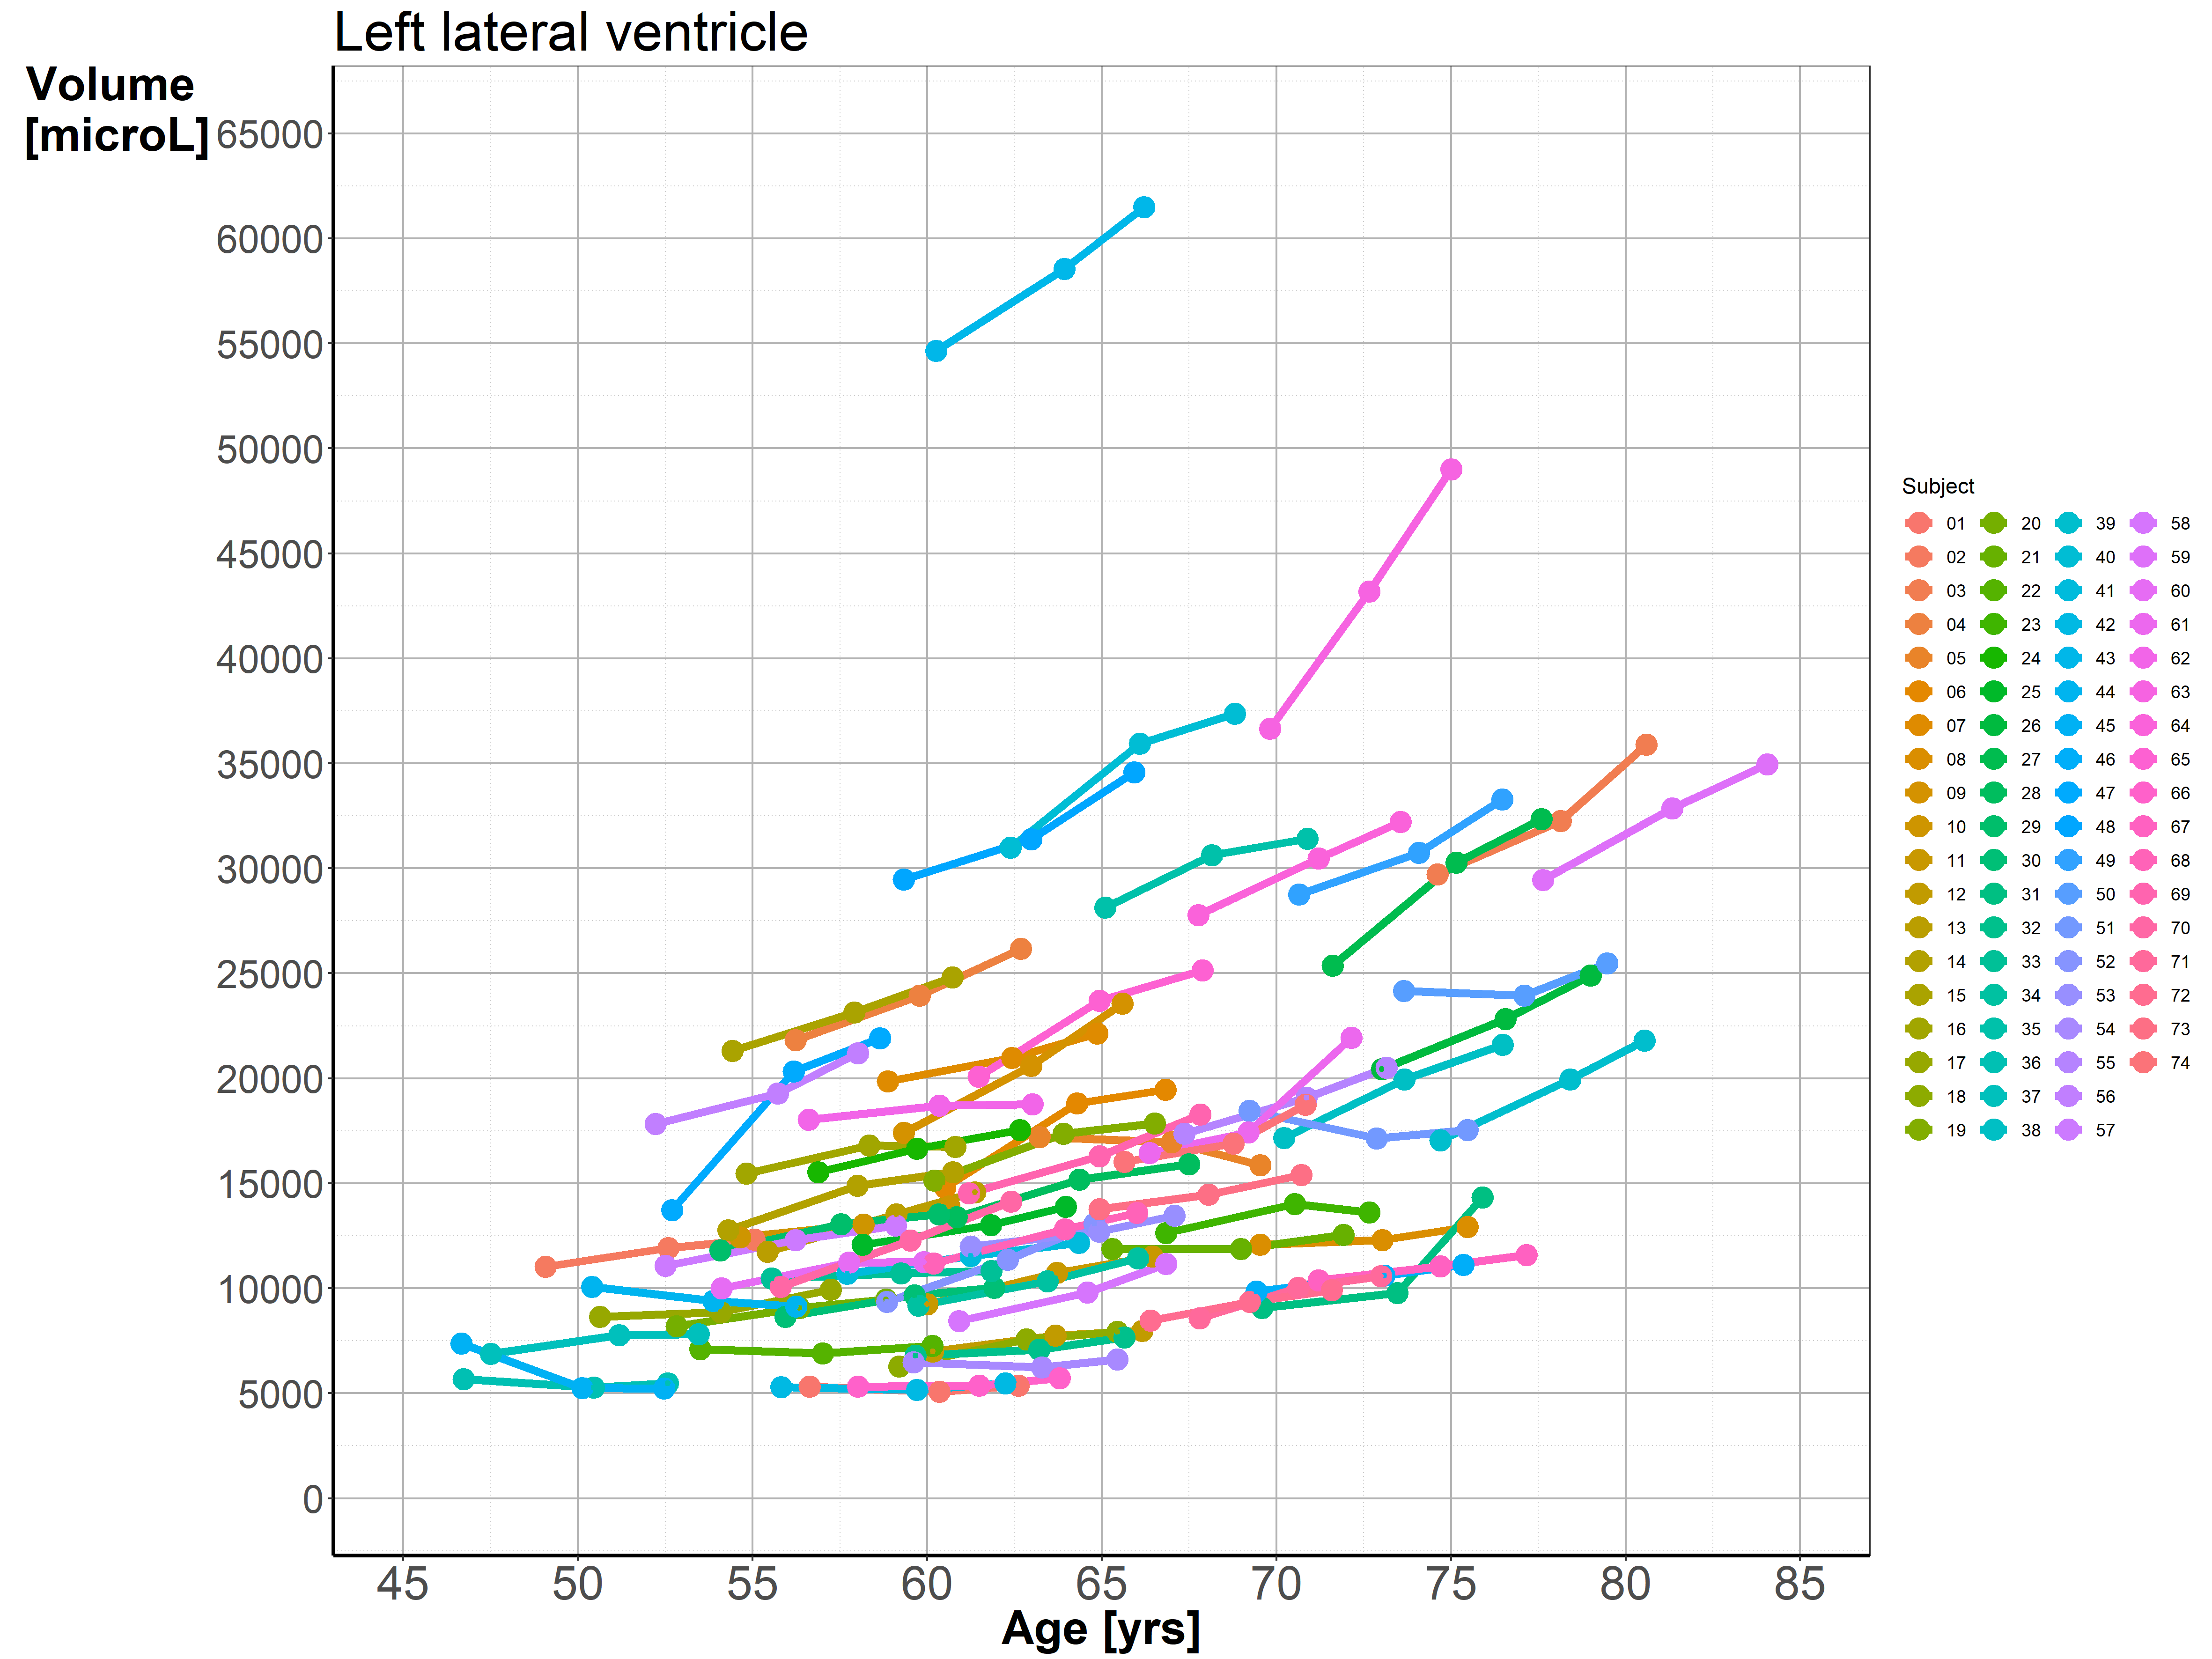

In [33]:
# %R print(g11)
Image(filename='../images/lvv_ri_rpy2_left_ventricle.png', width=900)

In [34]:
%%R

# Right lateral ventricle

df <-  df.longR

title.1.R <- "Right lateral ventricle"

mytitle <- title.1.R

g12 <- ggplot(data = df, aes(x = Age, y = Volume, group = Subject, colour = factor(Subject))) + geom_line(size=2)
g12 <- g12 + scale_colour_discrete(name  ="Subject") + geom_point(pch=19, size = 5)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]") 

g12 <- g12 + geom_point(size = 1.0) + theme_bw() + myX + myY
g12 <- g12 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g12 <- g12 + theme(plot.title = element_text(size = rel(2.0)))
g12 <- g12 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g12 <- g12 + theme(axis.text = element_text(size = rel(1.5)))
g12 <- g12 + theme(axis.title.y = element_text(size = rel(1.8), angle = 0))
g12 <- g12 + theme(axis.title.x = element_text(size = rel(1.8), angle = 0))
g12 <- g12 + theme(panel.grid.major = element_line(colour = "gray70"))
g12 <- g12 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g12 <- g12 + theme(plot.background = element_rect(fill = "white"))

g12 <- g12 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g12 <- g12 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g12 <- g12 + theme(plot.title = element_text(size=28))
  
ggsave("../images/lvv_ri_rpy2_right_ventricle.pdf", width = 40, height = 30, units = "cm")
ggsave("../images/lvv_ri_rpy2_right_ventricle.png", width = 40, height = 30, units = "cm")

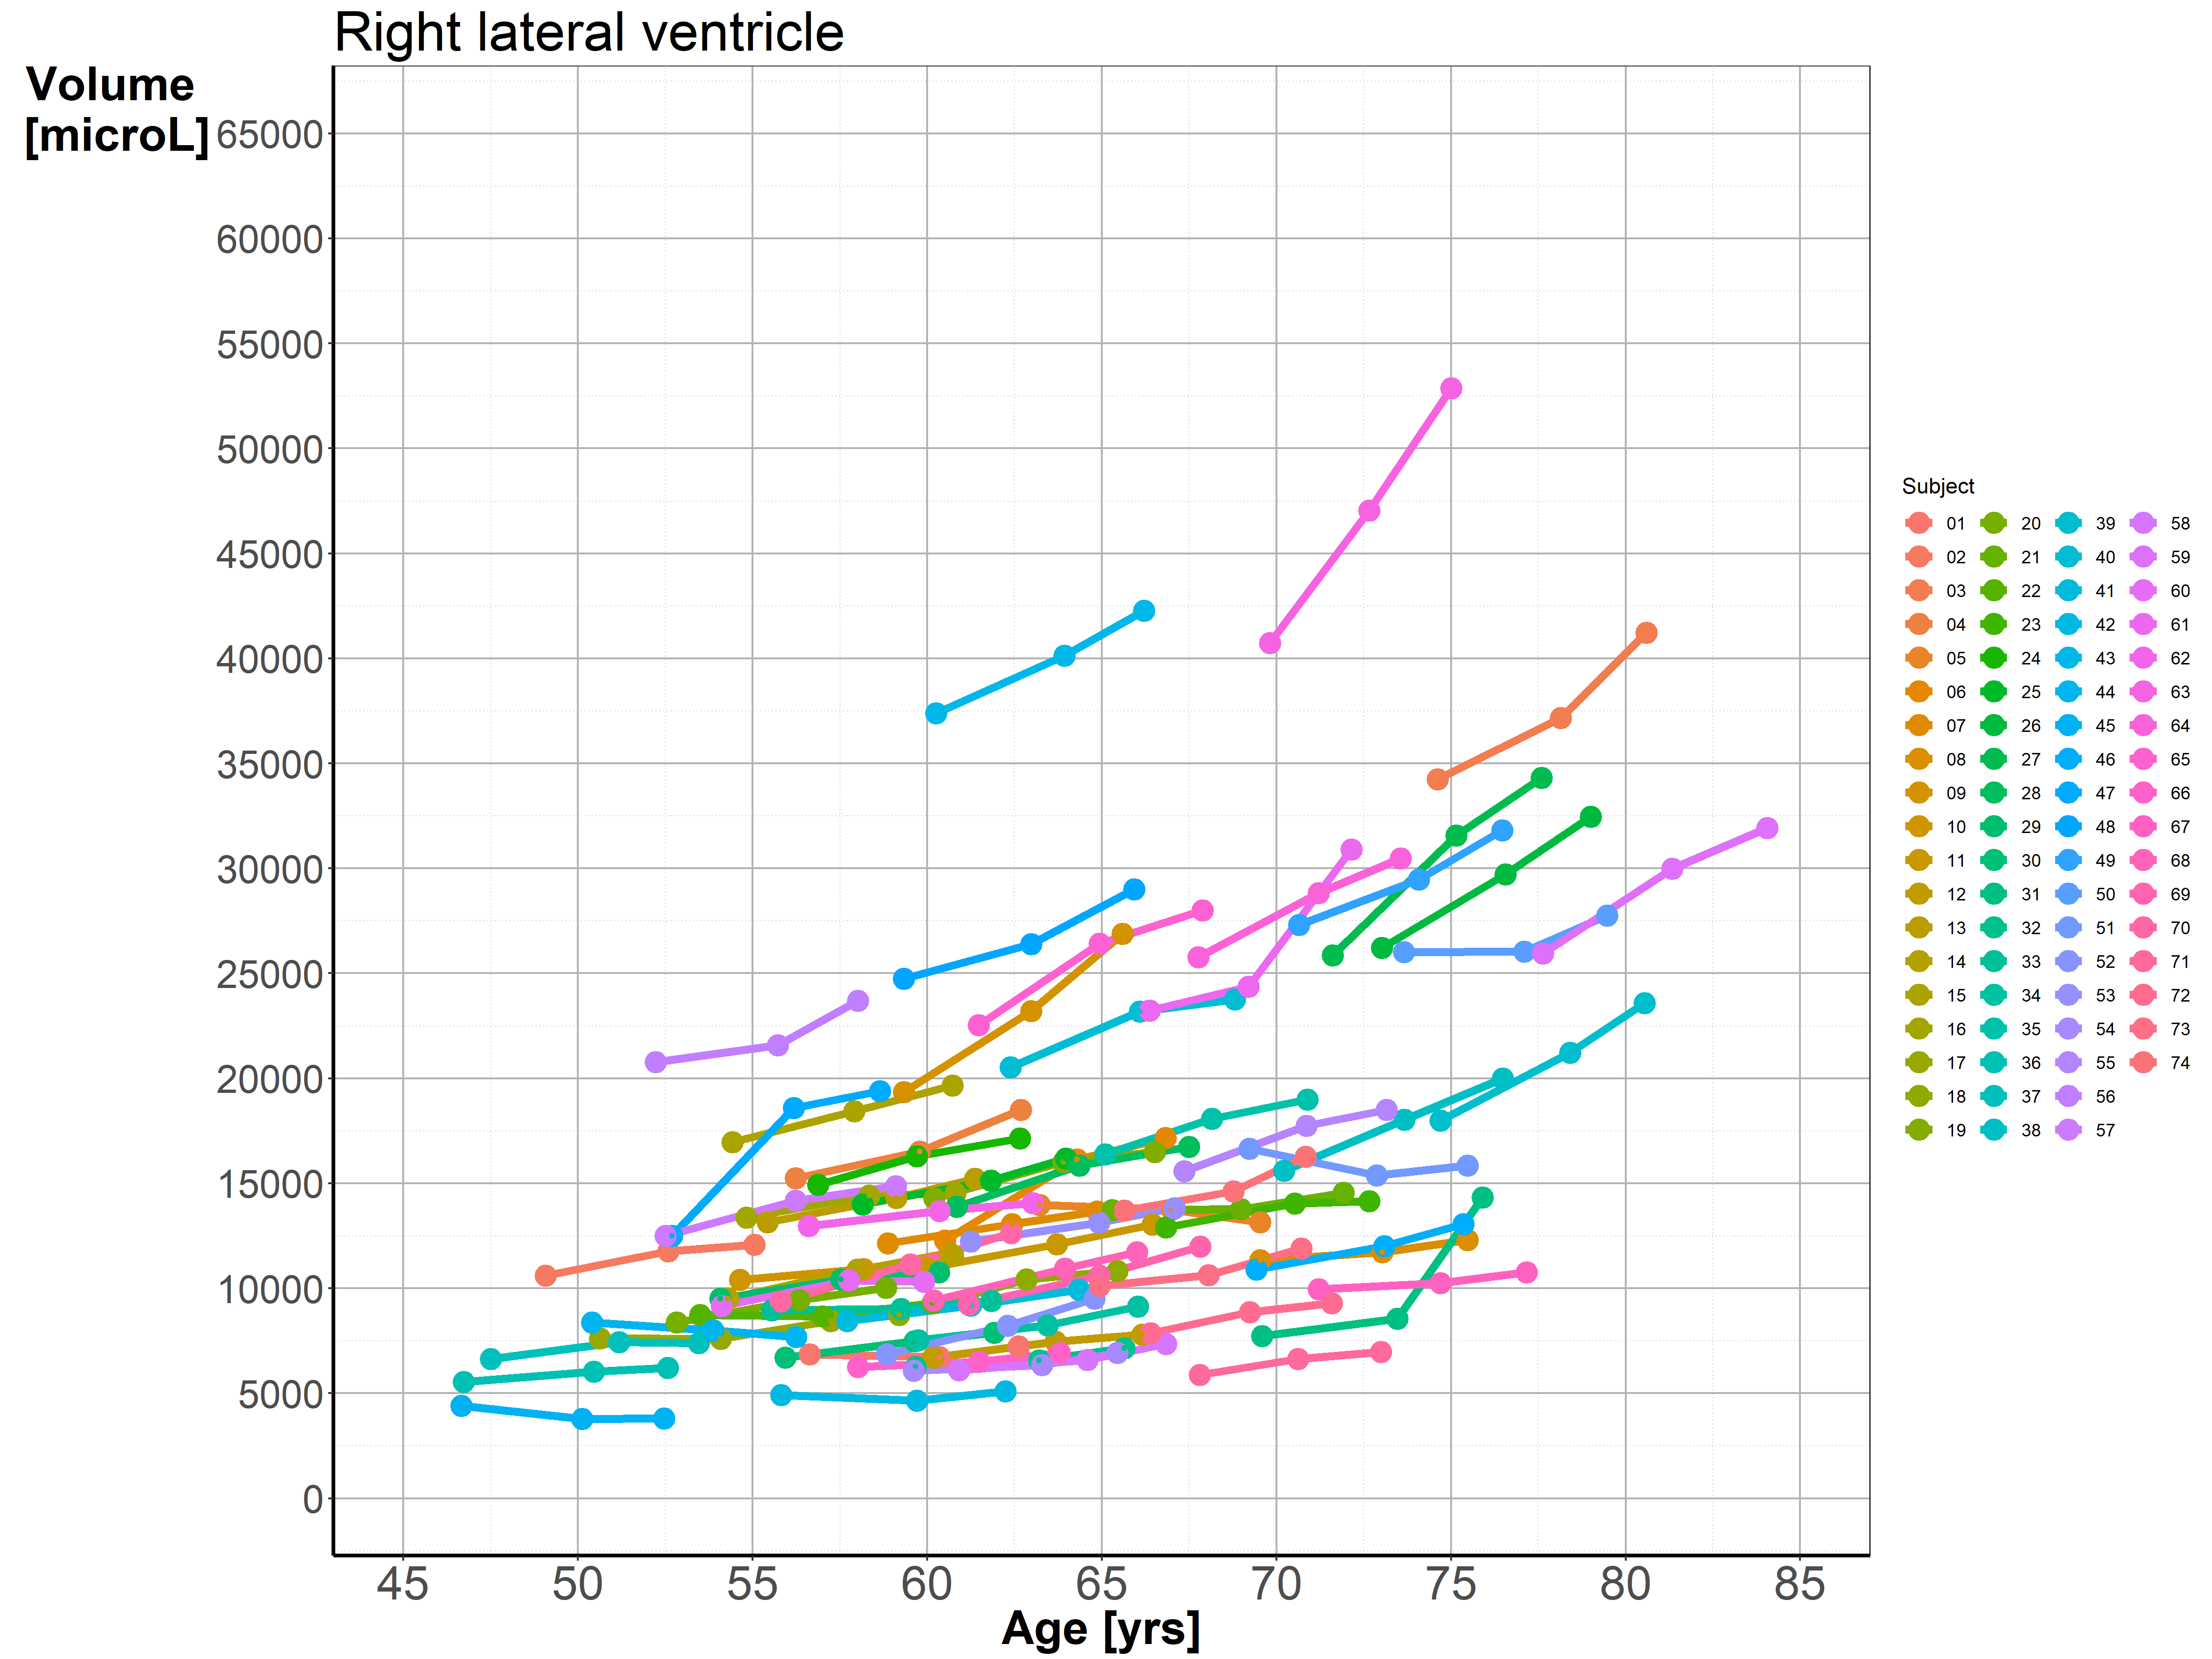

In [35]:
# %R plot(g12)
Image(filename='../images/lvv_ri_rpy2_right_ventricle.png', width=900)

In [36]:
%%R

df <-  df.longL
mylm <- lm.1.L
mylmer <- lmer.1.L
mytitle <- title.1.L

g21 <- ggplot(data = df, aes(x = Age, y = Volume, group = Subject, colour = factor(Subject))) + geom_line(size=1)
g21 <- g21 + scale_colour_discrete(name  ="Subject") + geom_point(pch=19, size = 4)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]")

g21 <- g21 + geom_point(size = 4.0) + theme_bw() + myX + myY
g21 <- g21 + geom_abline(intercept = a0.L, slope = a1.L, linetype = "dashed", size=2.0, colour = "red")
g21 <- g21 + geom_abline(intercept = beta0.L, slope = beta1.L, linetype = "solid", size=2.0, colour = "black")
g21 <- g21 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g21 <- g21 + theme(plot.title = element_text(size = rel(1.7)))
g21 <- g21 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g21 <- g21 + theme(axis.text = element_text(size = rel(1.2)))
g21 <- g21 + theme(axis.title.y = element_text(size = rel(1.5), angle = 0))
g21 <- g21 + theme(axis.title.x = element_text(size = rel(1.5), angle = 0))
g21 <- g21 + theme(legend.position="none")
g21 <- g21 + theme(panel.grid.major = element_line(colour = "gray70"))
g21 <- g21 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g21 <- g21 + theme(plot.background = element_rect(fill = "white"))

g21 <- g21 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g21 <- g21 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g21 <- g21 + theme(plot.title = element_text(size=28))

# Focus on individual trajectories; first fit a simple linear model to each trajectory
n <- length(b0i.L)
for (i in 1:n) {
  myx <-  df$Age[df$Wave==1][i]
  myxend <- df$Age[df$Wave==3][i]
  myy <- (beta0.L + b0i.L[i]) + (beta1.L + b1i.L[i])*myx
  myyend <- (beta0.L + b0i.L[i]) + (beta1.L + b1i.L[i])*myxend
  g21 <- g21 + annotate("segment", x = myx, xend = myxend, y = myy, yend = myyend, colour = "black", size = 0.3)
}
  
ggsave("../images/lvv_ri_rpy2_lmer_left_ventricle.pdf", width = 40, height = 30, units = "cm")
ggsave("../images/lvv_ri_rpy2_lmer_left_ventricle.png", width = 40, height = 30, units = "cm")

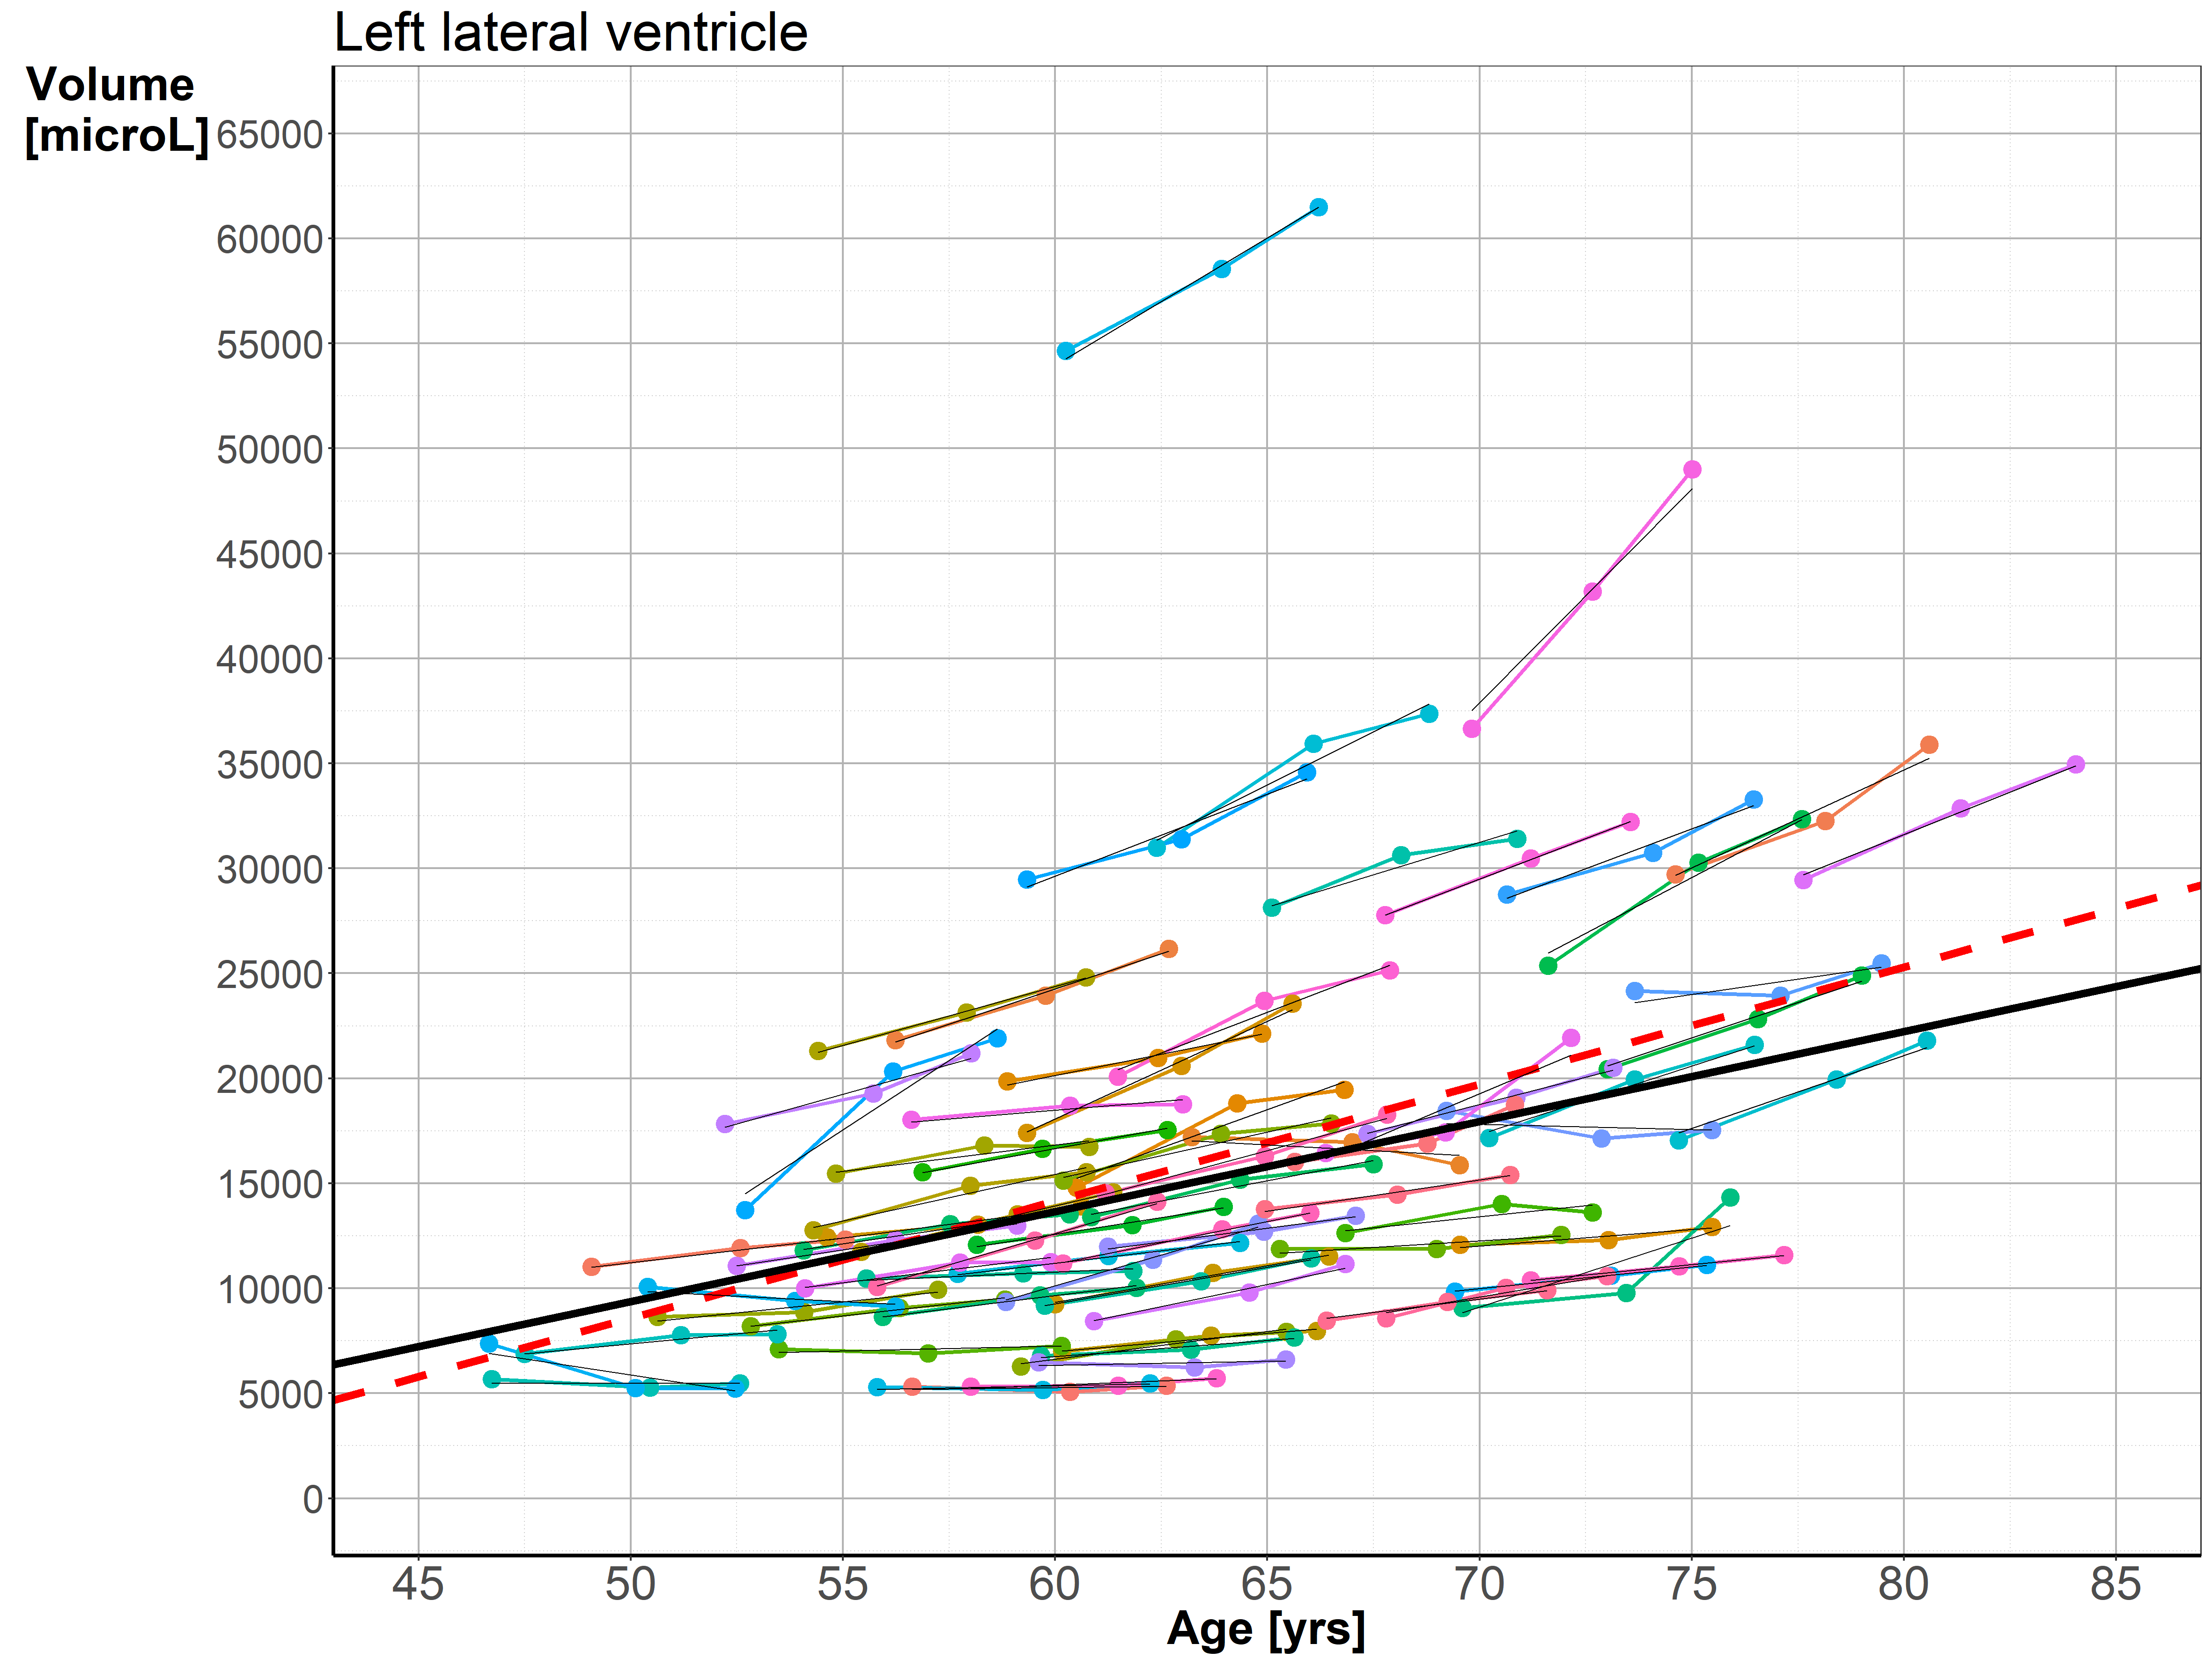

In [37]:
# %R print(g21)
Image(filename='../images/lvv_ri_rpy2_lmer_left_ventricle.png', width=900)

In [38]:
%%R

df <-  df.longR
mylm <- lm.1.R
mylmer <- lmer.1.R
mytitle <- title.1.R

g22 <- ggplot(data = df, aes(x = Age, y = Volume, group = Subject, colour = factor(Subject))) + geom_line(size=1)
g22 <- g22 + scale_colour_discrete(name  ="Subject") + geom_point(pch=19, size = 4)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]")

g22 <- g22 + geom_point(size = 1.0) + theme_bw() + myX + myY
g22 <- g22 + geom_abline(intercept = a0.R, slope = a1.R, linetype = "dashed", size=2.0, colour = "red")
g22 <- g22 + geom_abline(intercept = beta0.R, slope = beta1.R, linetype = "solid", size=2.0, colour = "black")
g22 <- g22 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g22 <- g22 + theme(plot.title = element_text(size = rel(1.7)))
g22 <- g22 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g22 <- g22 + theme(axis.text = element_text(size = rel(1.2)))
g22 <- g22 + theme(axis.title.y = element_text(size = rel(1.5), angle = 0))
g22 <- g22 + theme(axis.title.x = element_text(size = rel(1.5), angle = 0))
g22 <- g22 + theme(legend.position="none")
g22 <- g22 + theme(panel.grid.major = element_line(colour = "gray70"))
g22 <- g22 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g22 <- g22 + theme(plot.background = element_rect(fill = "white"))

g22 <- g22 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g22 <- g22 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g22 <- g22 + theme(plot.title = element_text(size=28))


# Focus on individual trajectories; first fit a simple linear model to each trajectory
n <- length(b0i.R)
for (i in 1:n) {
  myx <-  df$Age[df$Wave==1][i]
  myxend <- df$Age[df$Wave==3][i]
  myy <- (beta0.R + b0i.R[i]) + (beta1.R + b1i.R[i])*myx
  myyend <- (beta0.R + b0i.R[i]) + (beta1.R + b1i.R[i])*myxend
  g22 <- g22 + annotate("segment", x = myx, xend = myxend, y = myy, yend = myyend, colour = "black", size = 0.3)
}
  
ggsave("../images/lvv_ri_rpy2_lmer_right_ventricle.pdf", width = 40, height = 30, units = "cm")
ggsave("../images/lvv_ri_rpy2_lmer_right_ventricle.png", width = 40, height = 30, units = "cm")

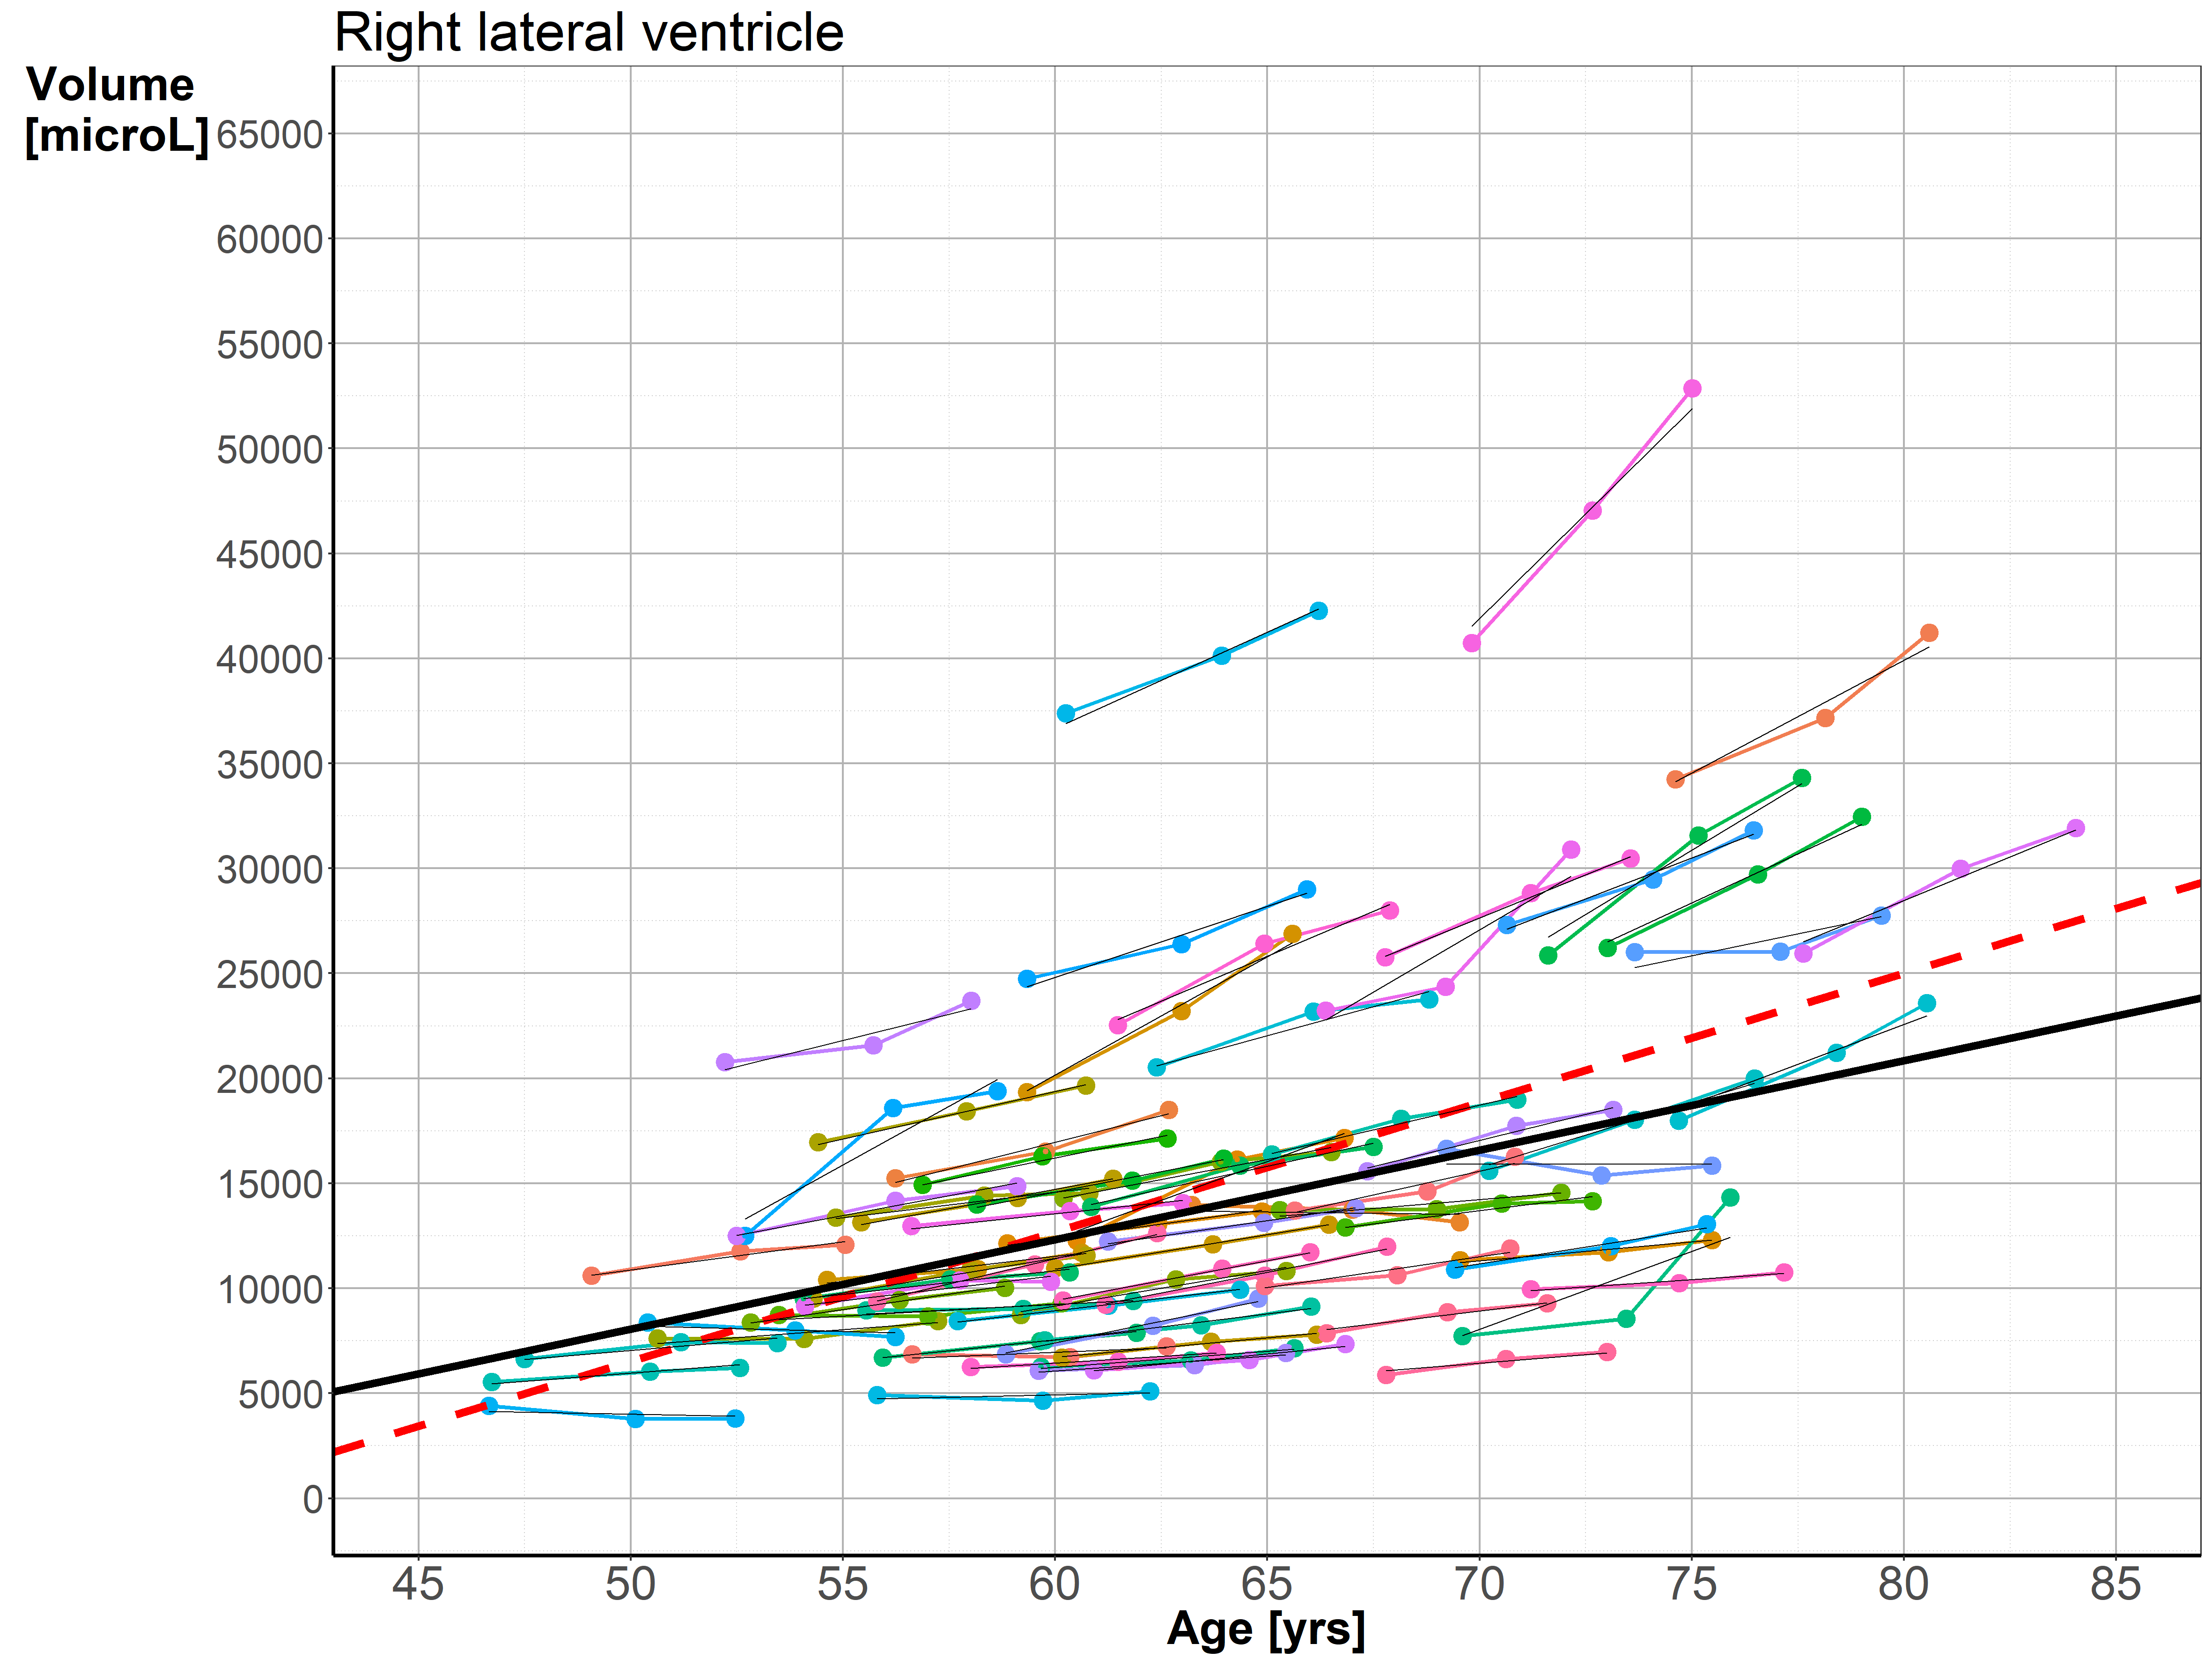

In [42]:
# %R print(g21)
Image(filename='../images/lvv_ri_rpy2_lmer_right_ventricle.png', width=900)

In [43]:
%R names(df.lmer.L)

array(['Subject', 'AcquisitionYearsW1', 'AcquisitionYearsW2',
       'AcquisitionYearsW3', 'Left.Lateral.Ventricle_W1',
       'Left.Lateral.Ventricle_W2', 'Left.Lateral.Ventricle_W3', 'b0i',
       'b1i', 'beta0plusb0i', 'beta1plusb1i', 'Sex', 'Stroop3'],
      dtype='<U25')

In [44]:
%%R 
x <- as.integer(substring(df.lmer.L$Subject,6, 7))
y <- df.lmer.L$Sex
df.lmer <- data.frame(x,y)
x_name <- "id"
y_name <- "Sex"
names(df.lmer) <- c(x_name,y_name)

df.lmer$Age1 = df.lmer.L$AcquisitionYearsW1
df.lmer$Age2 = df.lmer.L$AcquisitionYearsW2
df.lmer$Age3 = df.lmer.L$AcquisitionYearsW3

df.lmer$b0iL = df.lmer.L$b0i
df.lmer$b1iL = df.lmer.L$b1i
df.lmer$beta0plusb0iL = df.lmer.L$beta0plusb0i
df.lmer$beta1plusb1iL = df.lmer.L$beta1plusb1i

df.lmer$b0iR = df.lmer.R$b0i
df.lmer$b1iR = df.lmer.R$b1i
df.lmer$beta0plusb0iR = df.lmer.R$beta0plusb0i
df.lmer$beta1plusb1iR = df.lmer.R$beta1plusb1i

df.lmer$LatVentL1 = df.lmer.L$Left.Lateral.Ventricle_W1
df.lmer$LatVentL2 = df.lmer.L$Left.Lateral.Ventricle_W2
df.lmer$LatVentL3 = df.lmer.L$Left.Lateral.Ventricle_W3

df.lmer$LatVentR1 = df.lmer.R$Right.Lateral.Ventricle_W1
df.lmer$LatVentR2 = df.lmer.R$Right.Lateral.Ventricle_W2
df.lmer$LatVentR3 = df.lmer.R$Right.Lateral.Ventricle_W3

df.lmer$RI3 = df.lmer.L$Stroop3   # Response Inhibition, wave 3

In [45]:
%R print(colnames(df.lmer))

array(['id', 'Sex', 'Age1', 'Age2', 'Age3', 'b0iL', 'b1iL',
       'beta0plusb0iL', 'beta1plusb1iL', 'b0iR', 'b1iR', 'beta0plusb0iR',
       'beta1plusb1iR', 'LatVentL1', 'LatVentL2', 'LatVentL3',
       'LatVentR1', 'LatVentR2', 'LatVentR3', 'RI3'], dtype='<U13')

In [46]:
# Converting the R dataframes to Pandas DataFrames using Rpy2
# https://pandas.pydata.org/pandas-docs/stable/r_interface.html
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

pd_df_lmer = r['df.lmer']
pd_df_lmer.head().T.round(2)

0        1        2        3        4
id                   1        2        3        4        5
Sex                  F        M        M        M        M
Age1             56.63    49.07    74.61    56.23    63.22
Age2             60.35    52.58    78.14    59.78       67
Age3             62.62    55.05    80.59    62.68    69.53
b0iL           15786.4  11459.9 -27879.9 -3972.69  35804.7
b1iL          -403.143 -192.311  504.248   242.65 -535.182
beta0plusb0iL  3728.31 -598.217   -39938 -16030.8  23746.6
beta1plusb1iL  25.5885  236.421  932.979  671.381 -106.451
b0iR             15196  10583.5   -32889 -381.043  28445.9
b1iR          -342.562 -155.451  649.658  83.6578 -450.127
beta0plusb0iR  1956.43 -2656.06 -46128.6 -13620.6  15206.3
beta1plusb1iR  83.4235  270.535  1075.64  509.643 -24.1419
LatVentL1       5321.4  11038.6  29718.4  21830.1  17205.1
LatVentL2       5063.6  11912.2  32265.1  23933.6  16970.1
LatVentL3       5368.3  12313.3    35887  26164.2  15858.1
LatVentR1       6855.2  10611.6    34241  15243.9  13962.1
LatVentR2       6729.2  11774.8  37155.2  16505.1  13755.5
LatVentR3       7233.2  12070.5  41221.4  18509.1  13143.9
RI3                 66       85       71       41       62

In [47]:
pd_df_lmer.describe().T.round(2)

count      mean       std        min       25%       50%  \
id              74.0     37.50     21.51       1.00     19.25     37.50   
Age1            74.0     60.75      7.25      46.66     55.61     59.88   
Age2            74.0     64.28      7.21      50.11     59.32     63.56   
Age3            74.0     66.81      7.19      52.46     61.86     66.02   
b0iL            74.0      0.00  19108.38  -92465.14  -6894.05   3257.87   
b1iL            74.0     -0.00    370.11    -736.38   -219.94    -84.96   
beta0plusb0iL   74.0 -12058.08  19108.38 -104523.23 -18952.13  -8800.21   
beta1plusb1iL   74.0    428.73    370.11    -307.65    208.79    343.77   
b0iR            74.0      0.00  18775.33  -84955.13  -3666.57   5729.16   
b1iR            74.0     -0.00    357.16    -478.81   -236.86    -96.86   
beta0plusb0iR   74.0 -13239.56  18775.33  -98194.70 -16906.13  -7510.41   
beta1plusb1iR   74.0    425.99    357.16     -52.82    189.13    329.13   
LatVentL1       74.0  14994.10   8584.68    5303.10   9193.00  12259.60   
LatVentL2       74.0  16450.17   9589.52    5063.60  10110.88  13288.65   
LatVentL3       74.0  17605.22  10354.05    5235.00  11127.53  14225.50   
LatVentR1       74.0  13777.28   7743.45    4408.30   8394.15  12181.85   
LatVentR2       74.0  15183.76   8738.59    3777.00   8911.60  13089.90   
LatVentR3       74.0  16381.11   9646.09    3810.20   9615.98  13732.20   
RI3             74.0     56.99     14.46      35.00     46.00     54.50   

                    75%       max  
id                55.75     74.00  
Age1              66.39     77.63  
Age2              69.23     81.33  
Age3              72.09     84.05  
b0iL           10098.43  35804.73  
b1iL             213.99   1605.73  
beta0plusb0iL  -1959.65  23746.64  
beta1plusb1iL    642.72   2034.46  
b0iR           10642.13  28892.12  
b1iR              81.32   1575.21  
beta0plusb0iR  -2597.44  15652.56  
beta1plusb1iR    507.31   2001.20  
LatVentL1      17726.73  54646.70  
LatVentL2      19954.42  58559.10  
LatVentL3      21889.85  61501.40  
LatVentR1      16178.80  40721.30  
LatVentR2      18067.10  47038.50  
LatVentR3      19299.30  52859.40  
RI3               62.75    102.00

In [48]:
dff = pd_df_lmer.copy()
#pd.DataFrame(dff.count())
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 20 columns):
id               74 non-null int32
Sex              74 non-null category
Age1             74 non-null float64
Age2             74 non-null float64
Age3             74 non-null float64
b0iL             74 non-null float64
b1iL             74 non-null float64
beta0plusb0iL    74 non-null float64
beta1plusb1iL    74 non-null float64
b0iR             74 non-null float64
b1iR             74 non-null float64
beta0plusb0iR    74 non-null float64
beta1plusb1iR    74 non-null float64
LatVentL1        74 non-null float64
LatVentL2        74 non-null float64
LatVentL3        74 non-null float64
LatVentR1        74 non-null float64
LatVentR2        74 non-null float64
LatVentR3        74 non-null float64
RI3              74 non-null float64
dtypes: category(1), float64(18), int32(1)
memory usage: 10.9 KB


## Model-based (lmer) feature design

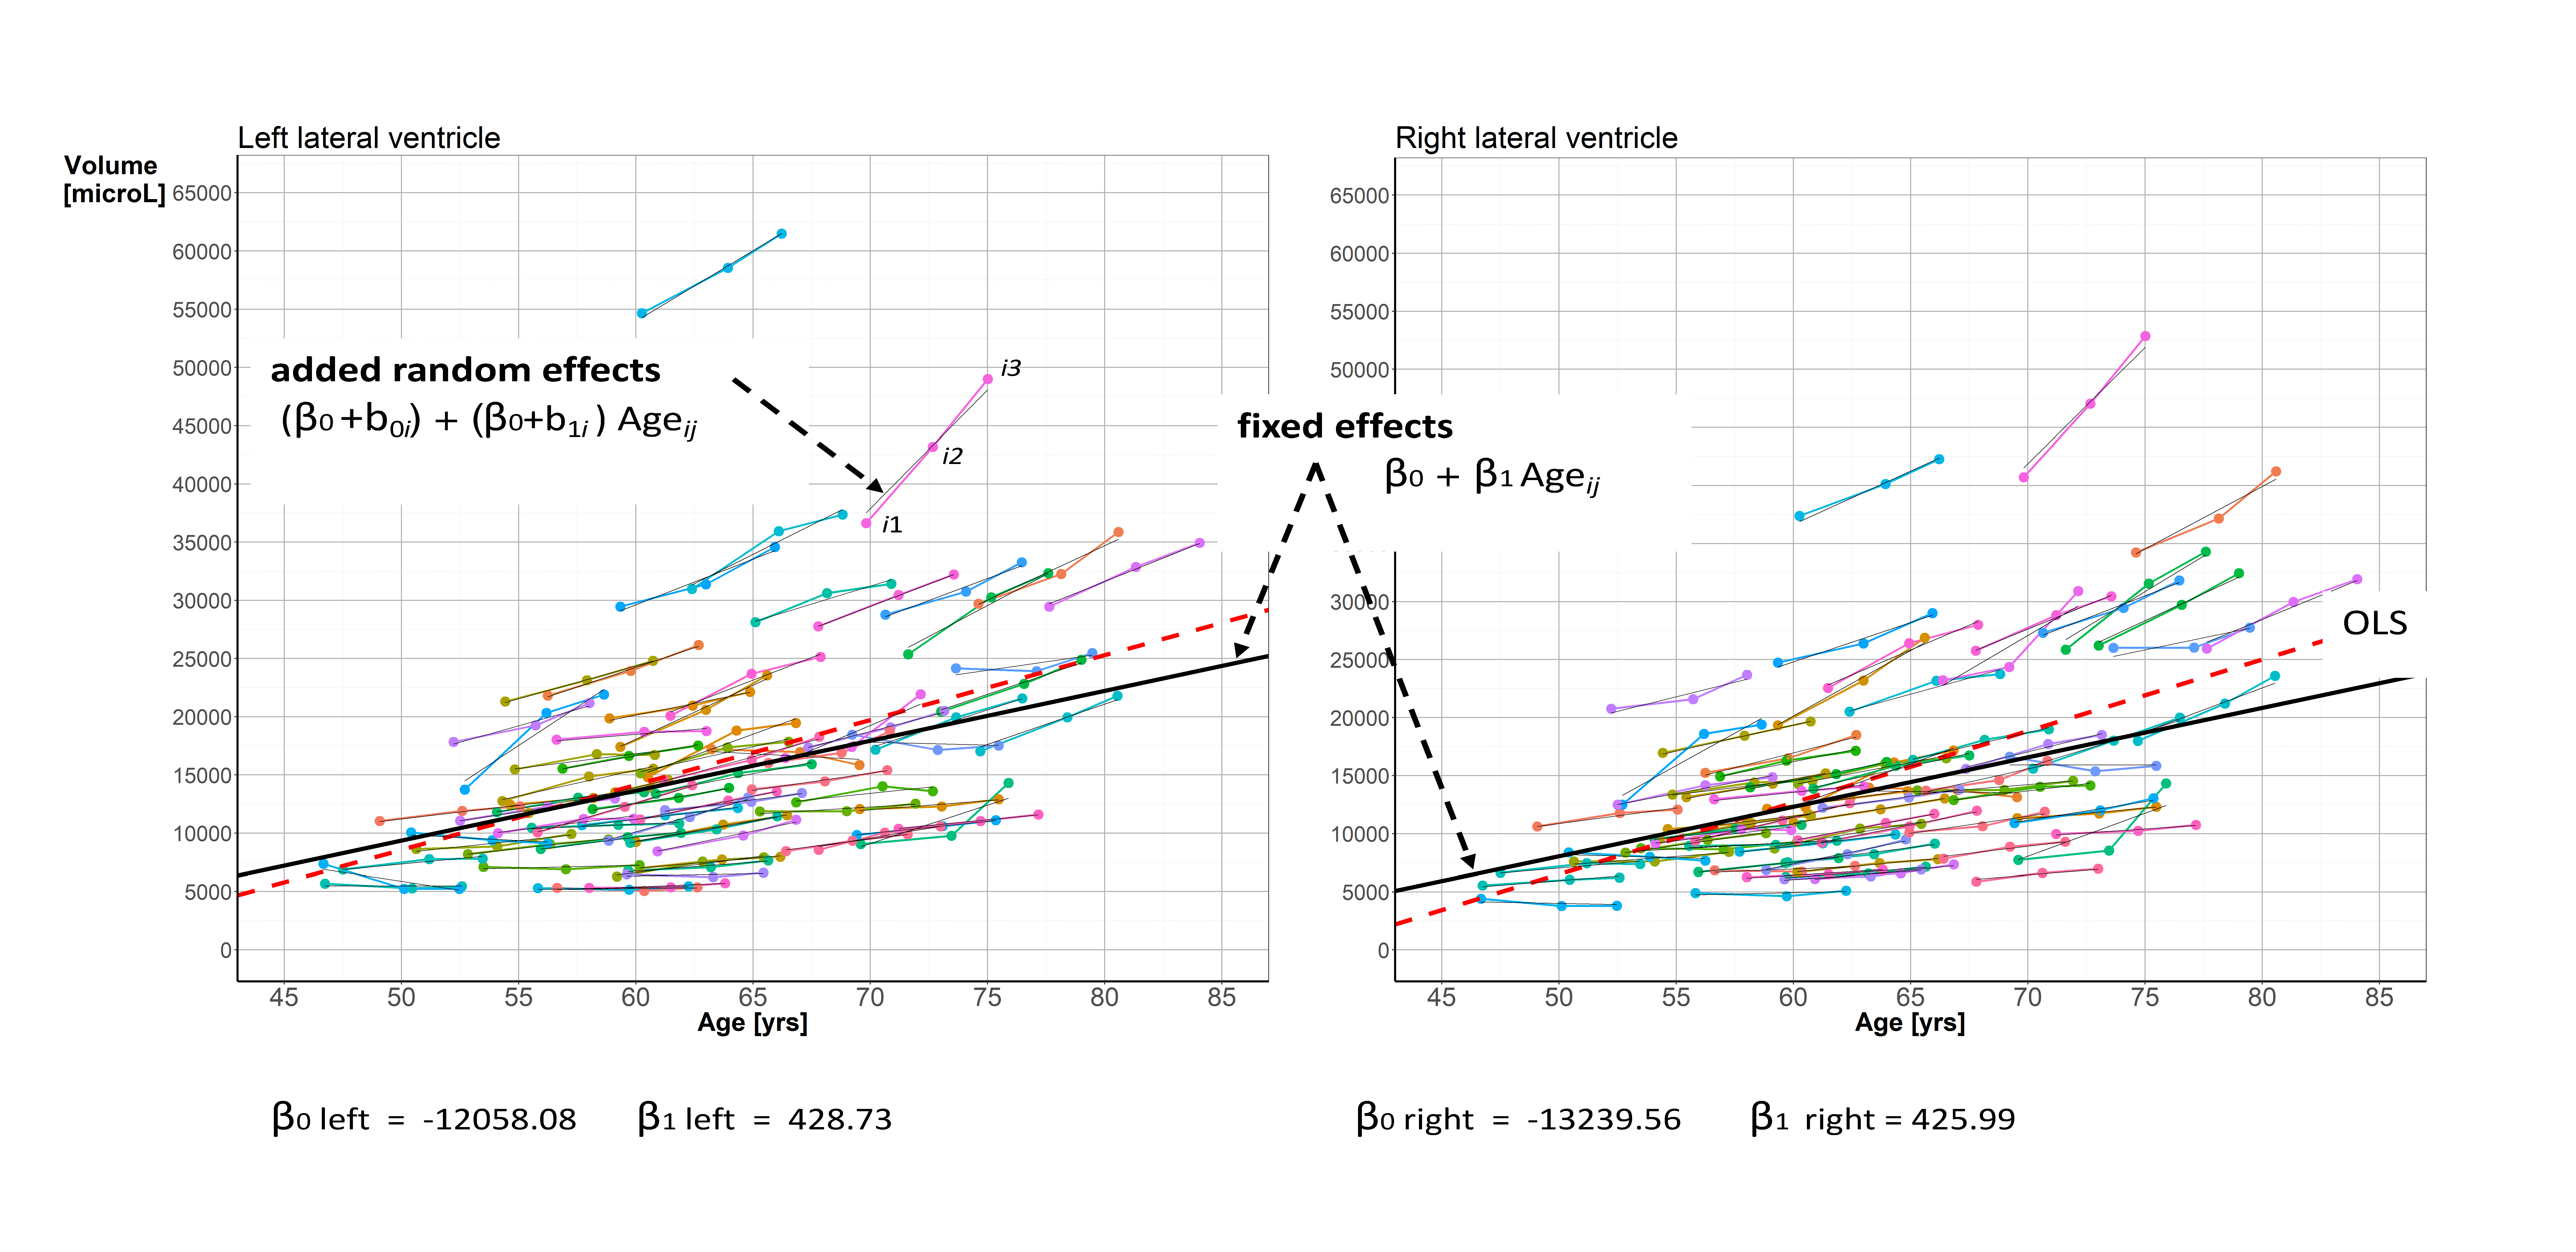

In [49]:
Image('../images/Figure_2.png', width=900)

In [50]:
# Derive new feature, related to wave1

def volFixed(x, a_f, b_f):
    '''
    Age at wave 1: x = dff.Age1
      a_f = dff.beta1L = dff.beta1plusb1iL - dff.b1iL
      b_f = dff.beta0plusb0iL - dff.b0iL
    Fixed effects: y_f = a_f x + b_f
    '''
    return a_f*x + b_f

    
def volDeviation(x, a_f, b_f, a_r, b_r):
    '''
    Age at wave 1: x = dff.Age1
    Fixed effects: y_f = a_f x + b_f
      a_f = dff.beta1L = dff.beta1plusb1iL - dff.b1iL
      b_f = dff.beta0plusb0iL - dff.b0iL
    Random effects: y_r = a_r x + b_r
      a_r = dff.beta1plusb1iL
      b_r = dff.beta0plusb0iL
    Vol_deviation = y_r - y_f
    '''

    y_f = a_f*x + b_f
    y_r = a_r*x + b_r
    return y_r - y_f

x = dff.Age1

# Left
a_f = dff.beta1plusb1iL - dff.b1iL
b_f = dff.beta0plusb0iL - dff.b0iL
a_r = dff.beta1plusb1iL
b_r = dff.beta0plusb0iL

print('LH fixed effects: (a_f, b_f) = (beta1L, beta0L) = (%.2f, %.2f)' % (a_f[0], b_f[0]))
dff['VdevL'] = volDeviation(x, a_f, b_f, a_r, b_r)
dff['Vfixed1L'] = volFixed(x, a_f, b_f)
dff['Vfixed1diffL'] = dff['LatVentL1'] - dff['Vfixed1L']


# Right
a_f = dff.beta1plusb1iR - dff.b1iR
b_f = dff.beta0plusb0iR - dff.b0iR
# a_r = dff.b1iR
a_r = dff.beta1plusb1iR
# b_r = dff.b0iR
b_r = dff.beta0plusb0iR

print('RH fixed effects: (a_f, b_f) = (beta1R, beta0R) = (%.2f, %.2f)' % (a_f[0], b_f[0]))
dff['VdevR'] = volDeviation(x, a_f, b_f, a_r, b_r)
dff['Vfixed1R'] = volFixed(x, a_f, b_f)
dff['Vfixed1diffR'] = dff['LatVentR1'] - dff['Vfixed1R']

LH fixed effects: (a_f, b_f) = (beta1L, beta0L) = (428.73, -12058.08)
RH fixed effects: (a_f, b_f) = (beta1R, beta0R) = (425.99, -13239.56)


In [51]:
pd.DataFrame(dff[['id', 'Age1', 'b0iL', 'b1iL', 'LatVentL1', 'Vfixed1L', 'Vfixed1diffL', 'VdevL']].round(2)).head()

id   Age1      b0iL    b1iL  LatVentL1  Vfixed1L  Vfixed1diffL    VdevL
0   1  56.63  15786.39 -403.14     5321.4  12220.99      -6899.59 -7043.60
1   2  49.07  11459.87 -192.31    11038.6   8979.77       2058.83  2023.17
2   3  74.61 -27879.92  504.25    29718.4  19929.58       9788.82  9742.00
3   4  56.23  -3972.69  242.65    21830.1  12049.49       9780.61  9671.50
4   5  63.22  35804.73 -535.18    17205.1  15046.33       2158.77  1970.51

In [52]:
dff['errorL'] = dff['Vfixed1diffL'] - dff['VdevL']

In [53]:
pd.DataFrame(dff[['id', 'Age1', 'b0iR', 'b1iR', 'LatVentR1', 'Vfixed1R', 'Vfixed1diffR', 'VdevR']].round(2)).head()

id   Age1      b0iR    b1iR  LatVentR1  Vfixed1R  Vfixed1diffR     VdevR
0   1  56.63  15195.99 -342.56     6855.2  10883.99      -4028.79  -4203.29
1   2  49.07  10583.50 -155.45    10611.6   7663.54       2948.06   2955.53
2   3  74.61 -32888.99  649.66    34241.0  18543.21      15697.79  15582.02
3   4  56.23   -381.04   83.66    15243.9  10713.60       4530.30   4323.03
4   5  63.22  28445.86 -450.13    13962.1  13691.24        270.86    -11.19

In [54]:
dff['errorR'] = dff['Vfixed1diffR'] - dff['VdevR']

In [55]:
pd.DataFrame(dff[['Age1', 'b0iL', 'b1iL', 'LatVentL1', 'Vfixed1L', 'Vfixed1diffL', 'VdevL', 'errorL']].mean().round(5))

0
Age1             60.74824
b0iL              0.00000
b1iL             -0.00000
LatVentL1     14994.09730
Vfixed1L      13986.60607
Vfixed1diffL   1007.49123
VdevL          1002.89675
errorL            4.59448

In [56]:
pd.DataFrame(dff[['Age1', 'b0iR', 'b1iR', 'LatVentR1', 'Vfixed1R', 'Vfixed1diffR', 'VdevR', 'errorR']].mean().round(5))

0
Age1             60.74824
b0iR              0.00000
b1iR             -0.00000
LatVentR1     13777.27703
Vfixed1R      12638.30312
Vfixed1diffR   1138.97390
VdevR          1126.01429
errorR           12.95961

### Check summary statistics

In [57]:
pd_df = dff.copy()
pd_df.describe(include=[np.number]).round(2).T

count      mean       std        min       25%       50%  \
id              74.0     37.50     21.51       1.00     19.25     37.50   
Age1            74.0     60.75      7.25      46.66     55.61     59.88   
Age2            74.0     64.28      7.21      50.11     59.32     63.56   
Age3            74.0     66.81      7.19      52.46     61.86     66.02   
b0iL            74.0      0.00  19108.38  -92465.14  -6894.05   3257.87   
b1iL            74.0     -0.00    370.11    -736.38   -219.94    -84.96   
beta0plusb0iL   74.0 -12058.08  19108.38 -104523.23 -18952.13  -8800.21   
beta1plusb1iL   74.0    428.73    370.11    -307.65    208.79    343.77   
b0iR            74.0      0.00  18775.33  -84955.13  -3666.57   5729.16   
b1iR            74.0     -0.00    357.16    -478.81   -236.86    -96.86   
beta0plusb0iR   74.0 -13239.56  18775.33  -98194.70 -16906.13  -7510.41   
beta1plusb1iR   74.0    425.99    357.16     -52.82    189.13    329.13   
LatVentL1       74.0  14994.10   8584.68    5303.10   9193.00  12259.60   
LatVentL2       74.0  16450.17   9589.52    5063.60  10110.88  13288.65   
LatVentL3       74.0  17605.22  10354.05    5235.00  11127.53  14225.50   
LatVentR1       74.0  13777.28   7743.45    4408.30   8394.15  12181.85   
LatVentR2       74.0  15183.76   8738.59    3777.00   8911.60  13089.90   
LatVentR3       74.0  16381.11   9646.09    3810.20   9615.98  13732.20   
RI3             74.0     56.99     14.46      35.00     46.00     54.50   
VdevL           74.0   1002.90   7791.55   -8928.98  -3813.56   -368.29   
Vfixed1L        74.0  13986.61   3110.35    7946.53  11784.75  13612.22   
Vfixed1diffL    74.0   1007.49   7776.83   -8712.55  -3802.08   -316.19   
VdevR           74.0   1126.01   6663.46   -9560.76  -3051.28   -338.84   
Vfixed1R        74.0  12638.30   3090.43    6636.92  10450.55  12266.31   
Vfixed1diffR    74.0   1138.97   6650.01   -9765.45  -3181.41   -362.84   
errorL          74.0      4.59    248.13    -882.79    -87.95     11.42   
errorR          74.0     12.96    280.76    -862.05    -64.34     27.43   

                    75%       max  
id                55.75     74.00  
Age1              66.39     77.63  
Age2              69.23     81.33  
Age3              72.09     84.05  
b0iL           10098.43  35804.73  
b1iL             213.99   1605.73  
beta0plusb0iL  -1959.65  23746.64  
beta1plusb1iL    642.72   2034.46  
b0iR           10642.13  28892.12  
b1iR              81.32   1575.21  
beta0plusb0iR  -2597.44  15652.56  
beta1plusb1iR    507.31   2001.20  
LatVentL1      17726.73  54646.70  
LatVentL2      19954.42  58559.10  
LatVentL3      21889.85  61501.40  
LatVentR1      16178.80  40721.30  
LatVentR2      18067.10  47038.50  
LatVentR3      19299.30  52859.40  
RI3               62.75    102.00  
VdevL           4047.25  40492.32  
Vfixed1L       16406.48  21224.35  
Vfixed1diffL    3821.58  40873.71  
VdevR           3809.64  25026.26  
Vfixed1R       15042.67  19829.69  
Vfixed1diffR    3349.17  24953.04  
errorL           147.74    602.94  
errorR           134.46    728.65

In [58]:
pd.DataFrame([pd_df['id'], pd_df['Age3'], pd_df['VdevL'], pd_df['VdevR']]).round(1)

0       1        2       3       4       5       6       7   \
id        1.0     2.0      3.0     4.0     5.0     6.0     7.0     8.0   
Age3     62.6    55.0     80.6    62.7    69.5    66.8    64.9    75.5   
VdevL -7043.6  2023.2   9742.0  9671.5  1970.5  1359.4  6505.4 -5823.2   
VdevR -4203.3  2955.5  15582.0  4323.0   -11.2   185.8   209.4 -5154.3   

           8      9    ...        64      65      66      67      68      69  \
id        9.0   10.0   ...      65.0    66.0    67.0    68.0    69.0    70.0   
Age3     65.6   60.6   ...      67.9    63.8    77.2    66.0    67.8    62.4   
VdevL  4081.1  928.4   ...    6117.5 -7586.4 -8080.7 -2518.2   300.3 -1753.0   
VdevR  7376.3  214.2   ...    9862.5 -5289.7 -7203.1 -2904.3 -3567.0 -1130.4   

           70      71      72      73  
id       71.0    72.0    73.0    74.0  
Age3     73.0    71.6    70.7    70.8  
VdevL -8167.0 -7840.0 -2119.9  -207.1  
VdevR -9560.8 -6996.2 -4400.2 -1105.4  

[4 rows x 74 columns]

### Select variables for analysis

In [59]:
pd_df.columns

Index(['id', 'Sex', 'Age1', 'Age2', 'Age3', 'b0iL', 'b1iL', 'beta0plusb0iL',
       'beta1plusb1iL', 'b0iR', 'b1iR', 'beta0plusb0iR', 'beta1plusb1iR',
       'LatVentL1', 'LatVentL2', 'LatVentL3', 'LatVentR1', 'LatVentR2',
       'LatVentR3', 'RI3', 'VdevL', 'Vfixed1L', 'Vfixed1diffL', 'VdevR',
       'Vfixed1R', 'Vfixed1diffR', 'errorL', 'errorR'],
      dtype='object')

In [60]:
myvars = [
    'id',
    'Sex',
    'Age3',
    'b1iL',
    'b1iR',
    'VdevL',
    'VdevR',
    'RI3',
]

In [61]:
pd_df.groupby("Sex")[myvars].describe(include="all", percentiles = [0.5]).round(2).T

Sex                 F        M
id    count        48       26
      unique      NaN      NaN
      top         NaN      NaN
      freq        NaN      NaN
      mean      39.81    33.23
      std       20.07    23.75
      min           1        2
      50%        37.5       34
      max          72       74
Sex   count        48       26
      unique        1        1
      top           F        M
      freq         48       26
      mean        NaN      NaN
      std         NaN      NaN
      min         NaN      NaN
      50%         NaN      NaN
      max         NaN      NaN
Age3  count        48       26
      unique      NaN      NaN
      top         NaN      NaN
      freq        NaN      NaN
      mean      66.42    67.54
      std        6.87     7.82
      min       52.57    52.46
      50%       65.54    66.76
      max       80.54    84.05
b1iL  count        48       26
      unique      NaN      NaN
      top         NaN      NaN
...               ...      ...
b1iR  min     -478.81  -461.54
      50%     -184.81    25.82
      max     1575.21   701.79
VdevL count        48       26
      unique      NaN      NaN
      top         NaN      NaN
      freq        NaN      NaN
      mean   -1193.91  5058.53
      std     5936.34  9200.25
      min    -8928.98  -5823.2
      50%    -1888.48  2994.11
      max     19647.1  40492.3
VdevR count        48       26
      unique      NaN      NaN
      top         NaN      NaN
      freq        NaN      NaN
      mean    -774.73  4635.08
      std     5918.29  6637.85
      min    -9560.76 -5154.31
      50%    -1079.06  3527.05
      max     25026.3  24467.4
RI3   count        48       26
      unique      NaN      NaN
      top         NaN      NaN
      freq        NaN      NaN
      mean      56.02    58.77
      std       14.95    13.62
      min          35       40
      50%        52.5       57
      max         102       94

[72 rows x 2 columns]

### $\LaTeX$ related

In [62]:
# print(pd_df.groupby("Sex")[myvars].describe(include="all", percentiles = [0.5]).round(2).T.to_latex())

#### Cut and paste LaTeX code to new cell
%%latex  cell

substitute tabular with array as "MathJax doesn't implement tabular", and toprule, midrule with hline <br>
https://github.com/mathjax/mathjax-docs/wiki/LaTeX-Tabular-environment


### Save lmer features

In [63]:
dfmri = pd_df.copy()
dfmri = dfmri[myvars].drop('id', axis=1)
dfmri.head().round(2)

Sex   Age3    b1iL    b1iR    VdevL     VdevR   RI3
0   F  62.62 -403.14 -342.56 -7043.60  -4203.29  66.0
1   M  55.05 -192.31 -155.45  2023.17   2955.53  85.0
2   M  80.59  504.25  649.66  9742.00  15582.02  71.0
3   M  62.68  242.65   83.66  9671.50   4323.03  41.0
4   M  69.53 -535.18 -450.13  1970.51    -11.19  62.0

In [64]:
# Save the lmer feature data to the present repository as .csv
dfmri.to_csv('../data/lvv_ri_lmer_feature_data.csv', header=True, index=False)

**Explorative plot**

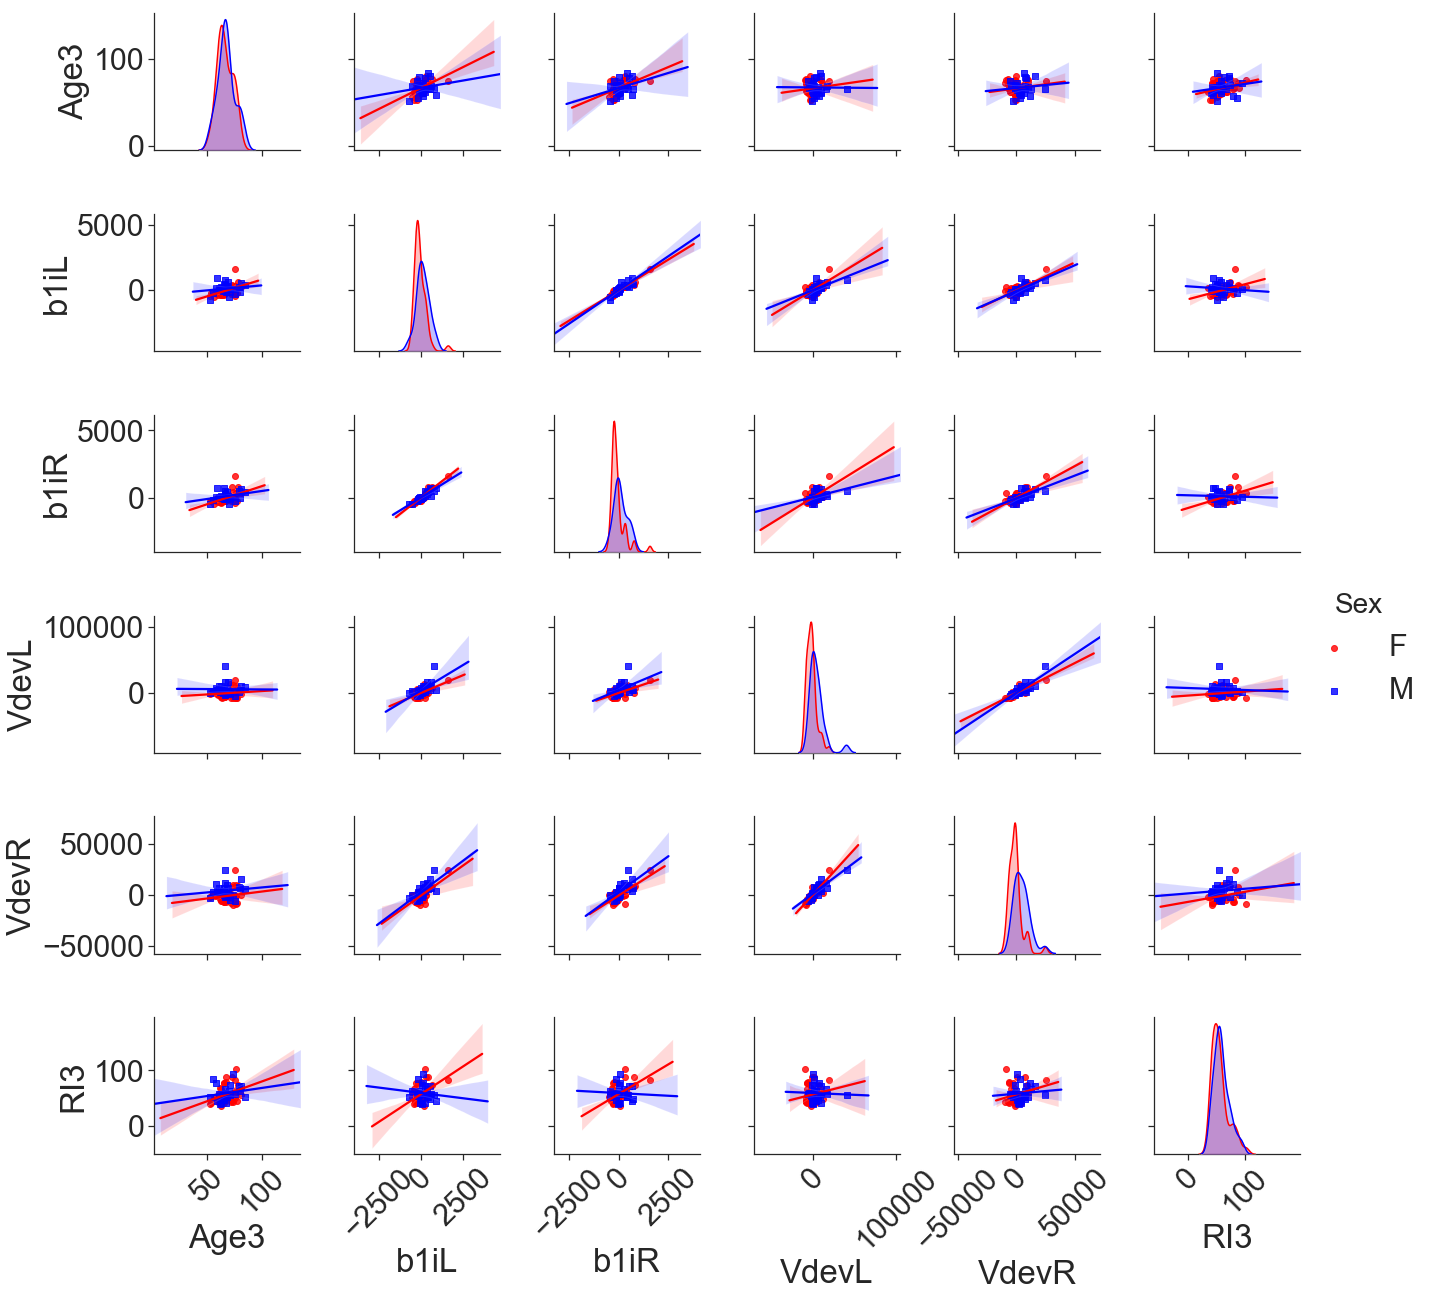

In [65]:
xvars = ['Sex', 'Age3', 'b1iL', 'b1iR', 'VdevL', 'VdevR', 'RI3']

myvars = [
    'Age3',
    'b1iL',
    'b1iR',
    'VdevL',
    'VdevR',
    'RI3',
]

mydf = dfmri.copy()
mydf.columns = xvars
mycolors = ["red", "blue"]
myfontscale = 2.75

mycol=sns.color_palette(mycolors)
sns.set(font_scale = myfontscale)
sns.set_style('whitegrid', {'axes.grid' : False})
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

g = sns.pairplot(
    mydf,
    hue = "Sex",
    hue_order = ["F", "M"],
    palette = mycol,
    vars = myvars,
    size = 3,
    diag_kind = "kde", 
    diag_kws = dict(shade=True),
    kind = "reg",
    markers=["o", "s"],
    aspect = 1
)

for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)


g.savefig('../images/lv_ri_sns_pairplot_by_sex.pdf', transparent=True)
g.savefig('../images/lv_ri_sns_pairplot_by_sex.png', transparent=True)

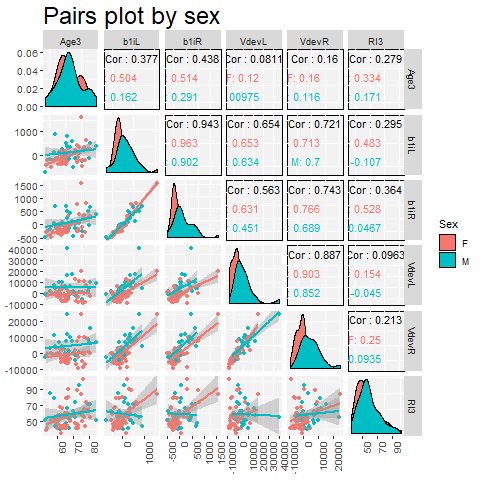

In [66]:
%%R -i mydf

library(ggplot2)
library(GGally)

data = mydf

pm <- ggpairs(
    data, mapping = aes(color = Sex), 
    title = "Pairs plot by sex",
    legend = 1,
    columns = c('Age3','b1iL','b1iR', 'VdevL', 'VdevR', 'RI3'),
  lower = list(
    continuous = 'smooth'
  )) 

pm = pm + theme(axis.text.x = element_text(angle = 90, hjust = 1))

pm = pm + theme(
  axis.text = element_text(size = 10),
  axis.title = element_text(size = 10),
  legend.background = element_rect(fill = "white"),
  panel.grid.major = element_line(colour = NA),
#  panel.grid.minor = element_blank(),
  panel.grid.minor = element_line(size = 0.25, linetype = 'solid', colour = "white"),
  panel.background = element_rect(fill = "grey95"),
  plot.title = element_text(size=24)
)

print(pm)

#         lower = list(
#     continuous = "smooth",
#     combo = ""facetdensity))

ggsave("../images/lvv_ri_rpy2_ggplot_ggpairs_lmer_vdev_by_sex.pdf", width = 30, height = 30, units = "cm")
ggsave("../images/lvv_ri_rpy2_ggplot_ggpairs_lmer_vdev_by_sex.png", width = 30, height = 30, units = "cm")

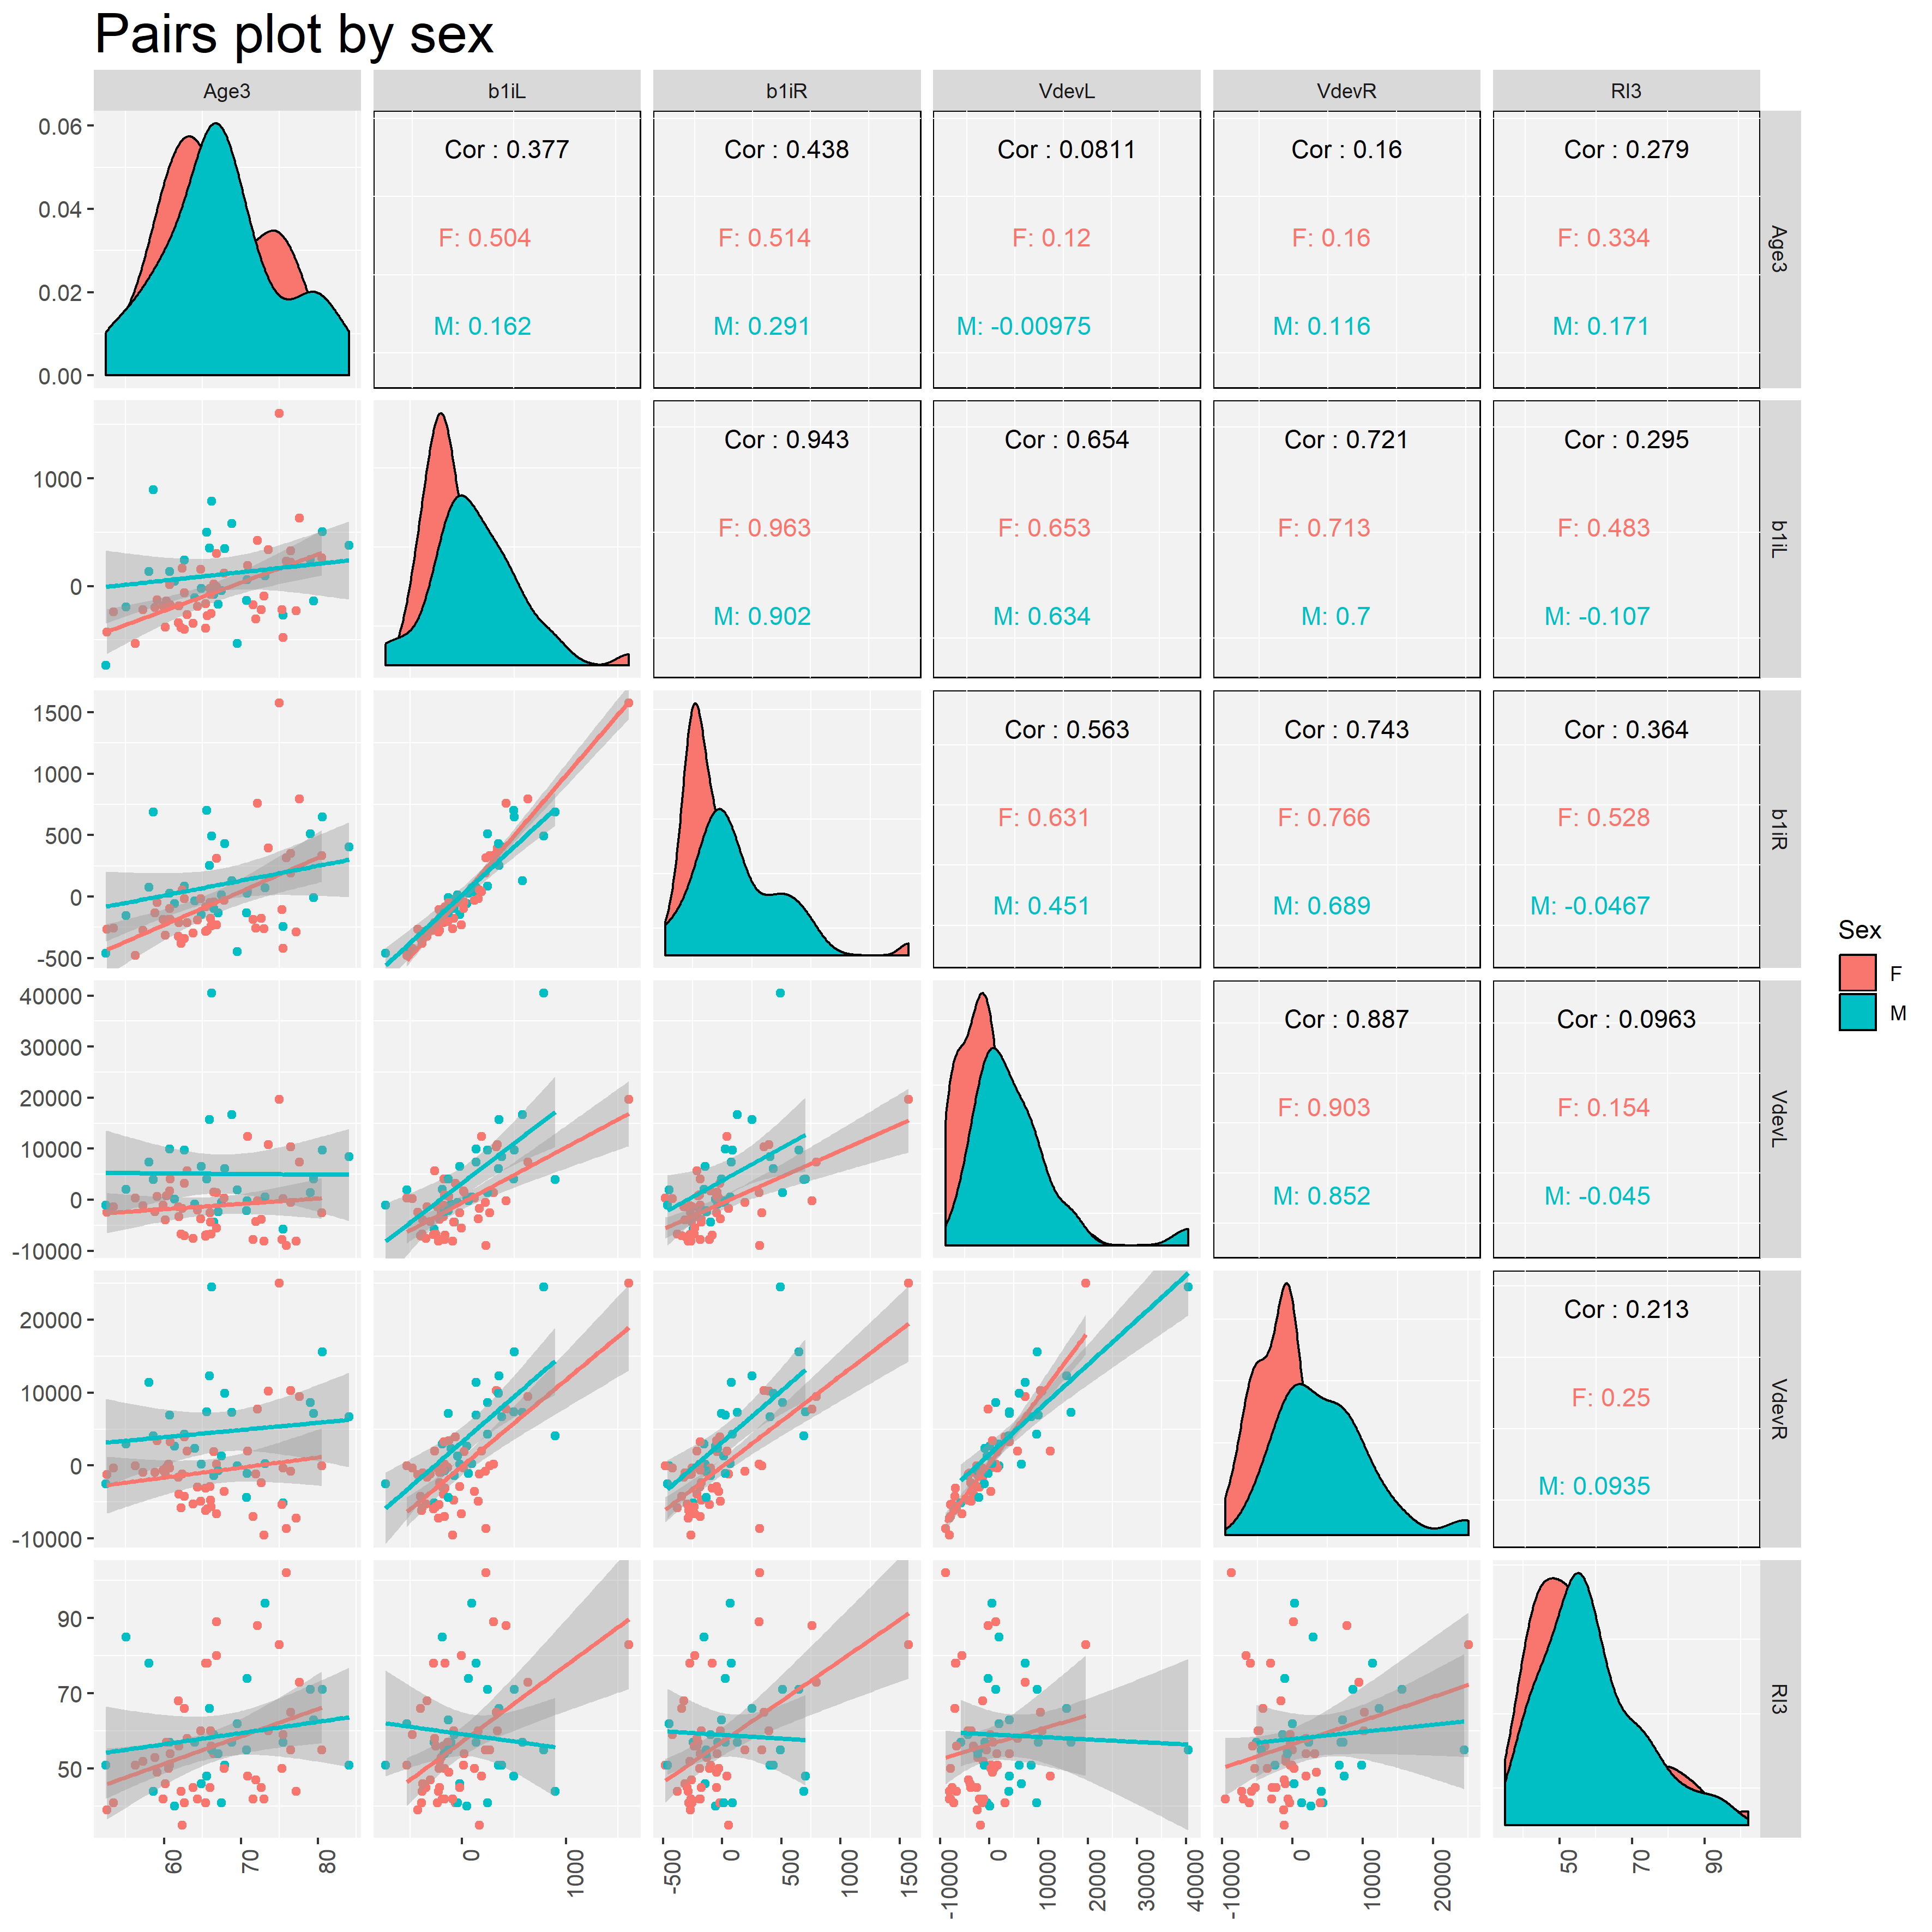

In [67]:
Image('../images/lvv_ri_rpy2_ggplot_ggpairs_lmer_vdev_by_sex.png')

## Discretization of outcome variable (RI3)

```python
pandas.qcut(x, q, labels=None, retbins=False, precision=3, duplicates='raise')
```
Quantile-based discretization function. Discretize variable into equal-sized buckets based on rank or based on sample quantiles. For example 1000 values for 10 quantiles would produce a Categorical object indicating quantile membership for each data point.

Since several data points might have the same Stroop3 (RI3) value, i.e.

In [68]:
behavior = 'RI3'
print('Total observations:', dfmri[behavior].size, ' Unique:', dfmri[behavior].unique().size)

Total observations: 74  Unique: 38


we first jitter (add some i.i.d. noise) to obtain unique values:

In [69]:
behaviorjitter = '%s_jitter' % (behavior)
pure = dfmri[behavior]
noise = np.random.normal(0, 0.1, pure.shape)
signal = pure + noise
dfmri[behaviorjitter] = signal
pd.concat([dfmri[behavior], dfmri[behaviorjitter]], axis=1).head(5).round(3)

RI3  RI3_jitter
0  66.0      66.091
1  85.0      84.981
2  71.0      70.958
3  41.0      41.076
4  62.0      61.964

In [70]:
# Check uniqueness of (jittered) RI3
print('Total observations:', dfmri[behaviorjitter].size, ' Unique:', dfmri[behaviorjitter].unique().size)

Total observations: 74  Unique: 74


In [71]:
# Make quintile cuts according to the jittered variable
behaviorcat = '%s_cat' % (behavior)
behaviorlabel = '%s_label' % (behavior)
pd.qcut(dfmri[behaviorjitter], 3).head(5)

0    (58.617, 101.87]
1    (58.617, 101.87]
2    (58.617, 101.87]
3     (34.89, 50.002]
4    (58.617, 101.87]
Name: RI3_jitter, dtype: category
Categories (3, interval[float64]): [(34.89, 50.002] < (50.002, 58.617] < (58.617, 101.87]]

In [72]:
pd.qcut(dfmri[behavior], 3).value_counts()

(34.999, 50.0]     27
(58.667, 102.0]    25
(50.0, 58.667]     22
Name: RI3, dtype: int64

In [73]:
# Better is:
pd.qcut(dfmri[behaviorjitter], 3).value_counts()

(58.617, 101.87]    25
(34.89, 50.002]     25
(50.002, 58.617]    24
Name: RI3_jitter, dtype: int64

In [74]:
# Perform and label the discretization of the original variable, introducing a new *_cat variable
discr, returnbins = pd.qcut(dfmri[behavior], 3, labels=["fast","medium","slow"], retbins=True, precision=3, duplicates='raise') #'drop' )
print('returnbins:', returnbins)
_df = pd.DataFrame([dfmri[behavior], discr]).T
_df.columns = [behavior, behaviorcat]
dfmri[behaviorcat] = _df[behaviorcat]
dfmri[behaviorcat].value_counts()

returnbins: [ 35.          50.          58.66666667 102.        ]


fast      27
slow      25
medium    22
Name: RI3_cat, dtype: int64

In [75]:
# Better is:
# Perform and label the discretization on the jittered variable, introducing a new *_label variable
discr, returnbins = pd.qcut(dfmri[behaviorjitter], 3, labels=["fast","medium","slow"], retbins=True, precision=3, duplicates='raise') #'drop' )
returnbins[0] = min([min(dfmri[behavior]), min(dfmri[behaviorjitter])]) - 0.001*min(dfmri[behavior])  # To secure proper lower interval
returnbins[-1] = max([max(dfmri[behavior]), max(dfmri[behaviorjitter])]) + 0.001*min(dfmri[behavior]) # To secure proper upper interval
returnbins_jitter = returnbins
print('returnbins:', returnbins)
_df = pd.DataFrame([dfmri[behavior], discr]).T
_df.columns = [behavior, behaviorlabel]
dfmri[behaviorlabel] = _df[behaviorlabel]
dfmri[behaviorlabel].value_counts()

returnbins: [ 34.85591692  50.00231619  58.61739202 102.035     ]


fast      25
slow      25
medium    24
Name: RI3_label, dtype: int64

In [76]:
vals, counts = np.unique(dfmri[behaviorlabel], return_counts=True)
print('Category counts (%s): %s %s' % (behaviorlabel, vals, counts))  # as good as it gets

Category counts (RI3_label): ['fast' 'medium' 'slow'] [25 24 25]


**Get the labels of *dfmri[behvarjitter]* usinge the bins computed by the jittered variable**

In [77]:
inds = np.digitize(dfmri[behaviorjitter], bins=returnbins, right=True)
inds.view()

array([3, 3, 3, 1, 3, 3, 1, 2, 1, 2, 3, 2, 1, 2, 2, 2, 2, 3, 2, 2, 1, 1,
       1, 1, 2, 3, 3, 1, 2, 2, 3, 3, 3, 3, 1, 1, 1, 2, 2, 2, 1, 1, 2, 2,
       2, 1, 1, 3, 3, 3, 3, 3, 2, 1, 3, 3, 1, 3, 2, 1, 3, 2, 3, 3, 2, 1,
       1, 1, 2, 1, 1, 1, 2, 3], dtype=int64)

In [78]:
x = dfmri[behavior]
xj = dfmri[behaviorjitter]
for n in range(x.size):
    print(n, returnbins[inds[n]-1].round(3), "<=", x[n], '(', xj[n].round(3), ')', "<", returnbins[inds[n]].round(3), '  ', inds[n], dfmri['Sex'][n])

0 58.617 <= 66.0 ( 66.091 ) < 102.035    3 F
1 58.617 <= 85.0 ( 84.981 ) < 102.035    3 M
2 58.617 <= 71.0 ( 70.958 ) < 102.035    3 M
3 34.856 <= 41.0 ( 41.076 ) < 50.002    1 M
4 58.617 <= 62.0 ( 61.964 ) < 102.035    3 M
5 58.617 <= 89.0 ( 89.101 ) < 102.035    3 F
6 34.856 <= 46.0 ( 45.98 ) < 50.002    1 M
7 50.002 <= 57.0 ( 56.832 ) < 58.617    2 M
8 34.856 <= 48.0 ( 47.971 ) < 50.002    1 M
9 50.002 <= 50.0 ( 50.039 ) < 58.617    2 F
10 58.617 <= 59.0 ( 58.922 ) < 102.035    3 M
11 50.002 <= 56.0 ( 56.036 ) < 58.617    2 F
12 34.856 <= 40.0 ( 40.039 ) < 50.002    1 M
13 50.002 <= 51.0 ( 51.107 ) < 58.617    2 F
14 50.002 <= 57.0 ( 57.083 ) < 58.617    2 M
15 50.002 <= 54.0 ( 54.284 ) < 58.617    2 F
16 50.002 <= 52.0 ( 51.734 ) < 58.617    2 F
17 58.617 <= 78.0 ( 77.846 ) < 102.035    3 F
18 50.002 <= 54.0 ( 53.927 ) < 58.617    2 F
19 50.002 <= 53.0 ( 52.943 ) < 58.617    2 F
20 34.856 <= 47.0 ( 46.949 ) < 50.002    1 F
21 34.856 <= 46.0 ( 46.105 ) < 50.002    1 F
22 34.856 <= 4

In [79]:
df_cat = pd.DataFrame(np.stack([x.as_matrix(), xj.as_matrix(), inds, dfmri.Sex.as_matrix()], axis=0).T)
df_cat.columns = ['RI3', 'RI3_jitter', 'RI3_cat', 'Sex']
df_cat.head(3)

RI3 RI3_jitter RI3_cat Sex
0  66    66.0912       3   F
1  85    84.9809       3   M
2  71    70.9579       3   M

In [80]:
# Make a dictionary
d={1:"fast", 2:"medium", 3:"slow"}
df_cat['RI3_label'] = df_cat.RI3_cat.map(d)
print(df_cat.columns)
df_cat.head(5)

Index(['RI3', 'RI3_jitter', 'RI3_cat', 'Sex', 'RI3_label'], dtype='object')


RI3 RI3_jitter RI3_cat Sex RI3_label
0  66    66.0912       3   F      slow
1  85    84.9809       3   M      slow
2  71    70.9579       3   M      slow
3  41     41.076       1   M      fast
4  62    61.9642       3   M      slow

In [81]:
print(returnbins)
df_cat.RI3_label.value_counts()

[ 34.85591692  50.00231619  58.61739202 102.035     ]


fast      25
slow      25
medium    24
Name: RI3_label, dtype: int64

In [82]:
# Crosstabe using non-jittered intervals
pd.crosstab(dfmri.RI3_cat,dfmri.Sex, margins=True)

Sex       F   M  All
RI3_cat             
fast     21   6   27
medium   12  10   22
slow     15  10   25
All      48  26   74

In [83]:
# Crosstab using the jitterd intervals (same number of datapoints in each "class")
pd.crosstab(dfmri.RI3_label,dfmri.Sex, margins=True)

Sex         F   M  All
RI3_label             
fast       19   6   25
medium     14  10   24
slow       15  10   25
All        48  26   74

**Check the difference between the non-jittered and jittered discretization**

In [84]:
Y1 = dfmri.loc[:, ['RI3_cat']]     # alternatively: y = df['grp']
y1 = Y1.values.ravel()
Y = dfmri.loc[:, ['RI3_label']]     # alternatively: y = df['grp']
y = Y.values.ravel()

_df = pd.DataFrame([y1, y])
_df = _df.T
_df.columns = ['RI3_cat', 'RI3_label']
print('Without jitter:')
print(_df['RI3_cat'].value_counts())
print('\nWith jitter:')
print(_df['RI3_label'].value_counts())
print('\nThe re-labelling:')
_df.loc[_df['RI3_cat'] != _df['RI3_label']]

Without jitter:
fast      27
slow      25
medium    22
Name: RI3_cat, dtype: int64

With jitter:
fast      25
slow      25
medium    24
Name: RI3_label, dtype: int64

The re-labelling:


RI3_cat RI3_label
9     fast    medium
68    fast    medium

In [85]:
dfmri.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 10 columns):
Sex           74 non-null category
Age3          74 non-null float64
b1iL          74 non-null float64
b1iR          74 non-null float64
VdevL         74 non-null float64
VdevR         74 non-null float64
RI3           74 non-null float64
RI3_jitter    74 non-null float64
RI3_cat       74 non-null object
RI3_label     74 non-null object
dtypes: category(1), float64(7), object(2)
memory usage: 5.4+ KB


In [86]:
myvars = ['Sex', 'Age3', 'b1iL', 'b1iR', 'VdevL', 'VdevR', 'RI3', 'RI3_label']
df_label = dfmri[myvars]
df_label.head()

Sex   Age3        b1iL        b1iR        VdevL         VdevR   RI3  \
0   F  62.62 -403.143034 -342.561962 -7043.602048  -4203.292419  66.0   
1   M  55.05 -192.310801 -155.450942  2023.174773   2955.526208  85.0   
2   M  80.59  504.247682  649.658359  9741.998107  15582.024184  71.0   
3   M  62.68  242.649643   83.657769  9671.495552   4323.033064  41.0   
4   M  69.53 -535.182165 -450.127330  1970.509513    -11.193543  62.0   

  RI3_label  
0      slow  
1      slow  
2      slow  
3      fast  
4      slow

In [87]:
# Save the lmer feature data to the present repository as .csv
df_label.to_csv('../data/lvv_ri_lmer_feature_data_label.csv', header=True, index=False)

### Spaghetti plot in R of LVV trajectories labelled with RI3 ('fast', 'medium', 'slow')

In [88]:
%R head(df.longL)

Subject                Region Wave    Age   Volume
0      01  LeftLateralVentricle    1  56.63   5321.4
1      01  LeftLateralVentricle    2  60.35   5063.6
2      01  LeftLateralVentricle    3  62.62   5368.3
3      02  LeftLateralVentricle    1  49.07  11038.6
4      02  LeftLateralVentricle    2  52.58  11912.2
5      02  LeftLateralVentricle    3  55.05  12313.3

In [89]:
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

pd_df_longL = r['df.longL']
pd_df_longL.head(4)

Subject                Region Wave    Age   Volume
0      01  LeftLateralVentricle    1  56.63   5321.4
1      01  LeftLateralVentricle    2  60.35   5063.6
2      01  LeftLateralVentricle    3  62.62   5368.3
3      02  LeftLateralVentricle    1  49.07  11038.6

In [90]:
dfL = pd_df_longL.copy()
dfL['id'] = dfL['Subject']
dfL = dfL.drop(['Region', 'Subject'], axis=1)
dfL.head(4)

Wave    Age   Volume  id
0    1  56.63   5321.4  01
1    2  60.35   5063.6  01
2    3  62.62   5368.3  01
3    1  49.07  11038.6  02

In [91]:
dfmriL = dfmri.copy()
dfmriL['id'] = pd_df['id']
dfmriL['RI3_label'] = df_cat['RI3_label']
dfmriL = dfmriL.drop(['Sex','Age3','b1iL','b1iR','VdevL','VdevR','RI3','RI3_jitter','RI3_cat'], axis=1)
dfmriL.head(4)

RI3_label  id
0      slow   1
1      slow   2
2      slow   3
3      fast   4

In [92]:
di = pd.Series(dfmriL.RI3_label.values,index=dfmriL.id).to_dict()
di.items()

dict_items([(1, 'slow'), (2, 'slow'), (3, 'slow'), (4, 'fast'), (5, 'slow'), (6, 'slow'), (7, 'fast'), (8, 'medium'), (9, 'fast'), (10, 'medium'), (11, 'slow'), (12, 'medium'), (13, 'fast'), (14, 'medium'), (15, 'medium'), (16, 'medium'), (17, 'medium'), (18, 'slow'), (19, 'medium'), (20, 'medium'), (21, 'fast'), (22, 'fast'), (23, 'fast'), (24, 'fast'), (25, 'medium'), (26, 'slow'), (27, 'slow'), (28, 'fast'), (29, 'medium'), (30, 'medium'), (31, 'slow'), (32, 'slow'), (33, 'slow'), (34, 'slow'), (35, 'fast'), (36, 'fast'), (37, 'fast'), (38, 'medium'), (39, 'medium'), (40, 'medium'), (41, 'fast'), (42, 'fast'), (43, 'medium'), (44, 'medium'), (45, 'medium'), (46, 'fast'), (47, 'fast'), (48, 'slow'), (49, 'slow'), (50, 'slow'), (51, 'slow'), (52, 'slow'), (53, 'medium'), (54, 'fast'), (55, 'slow'), (56, 'slow'), (57, 'fast'), (58, 'slow'), (59, 'medium'), (60, 'fast'), (61, 'slow'), (62, 'medium'), (63, 'slow'), (64, 'slow'), (65, 'medium'), (66, 'fast'), (67, 'fast'), (68, 'fast'), (

In [93]:
dfL['Subject']=dfL['id']
dfL['id']=dfL['id'].astype('int32')
dfL['id'].replace(di, inplace=True)
dfL['RI3_label']=dfL['id'].astype('category')
dfL = dfL.drop(['id'], axis=1)
dfL.head()

Wave    Age   Volume Subject RI3_label
0    1  56.63   5321.4      01      slow
1    2  60.35   5063.6      01      slow
2    3  62.62   5368.3      01      slow
3    1  49.07  11038.6      02      slow
4    2  52.58  11912.2      02      slow

In [94]:
%%R -i dfL

# Left lateral ventricle

df <-  dfL

title.1.L <- "Left lateral ventricle"

mytitle <- title.1.L

g11 <- ggplot(data = df, aes(x = Age, y = Volume, group = Subject, colour = factor(RI3_label))) + geom_line(size=2)
g11 <- g11 + scale_colour_discrete(name  ="RI3_label") + geom_point(pch=19, size = 5)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]") 

g11 <- g11 + geom_point(size = 1.0) + theme_bw() + myX + myY
g11 <- g11 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g11 <- g11 + theme(plot.title = element_text(size = rel(2.0)))
g11 <- g11 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g11 <- g11 + theme(axis.text = element_text(size = rel(1.5)))
g11 <- g11 + theme(axis.title.y = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(axis.title.x = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(panel.grid.major = element_line(colour = "gray70"))
g11 <- g11 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g11 <- g11 + theme(plot.background = element_rect(fill = "white"))

g11 <- g11 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g11 <- g11 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g11 <- g11 + theme(plot.title = element_text(size=28))

ggsave("../images/lvv_ri_rpy2_left_ventricle_by_RI3_label.pdf", width = 40, height = 30, units = "cm")
ggsave("../images/lvv_ri_rpy2_left_ventricle_by_RI3_label.png", width = 40, height = 30, units = "cm")

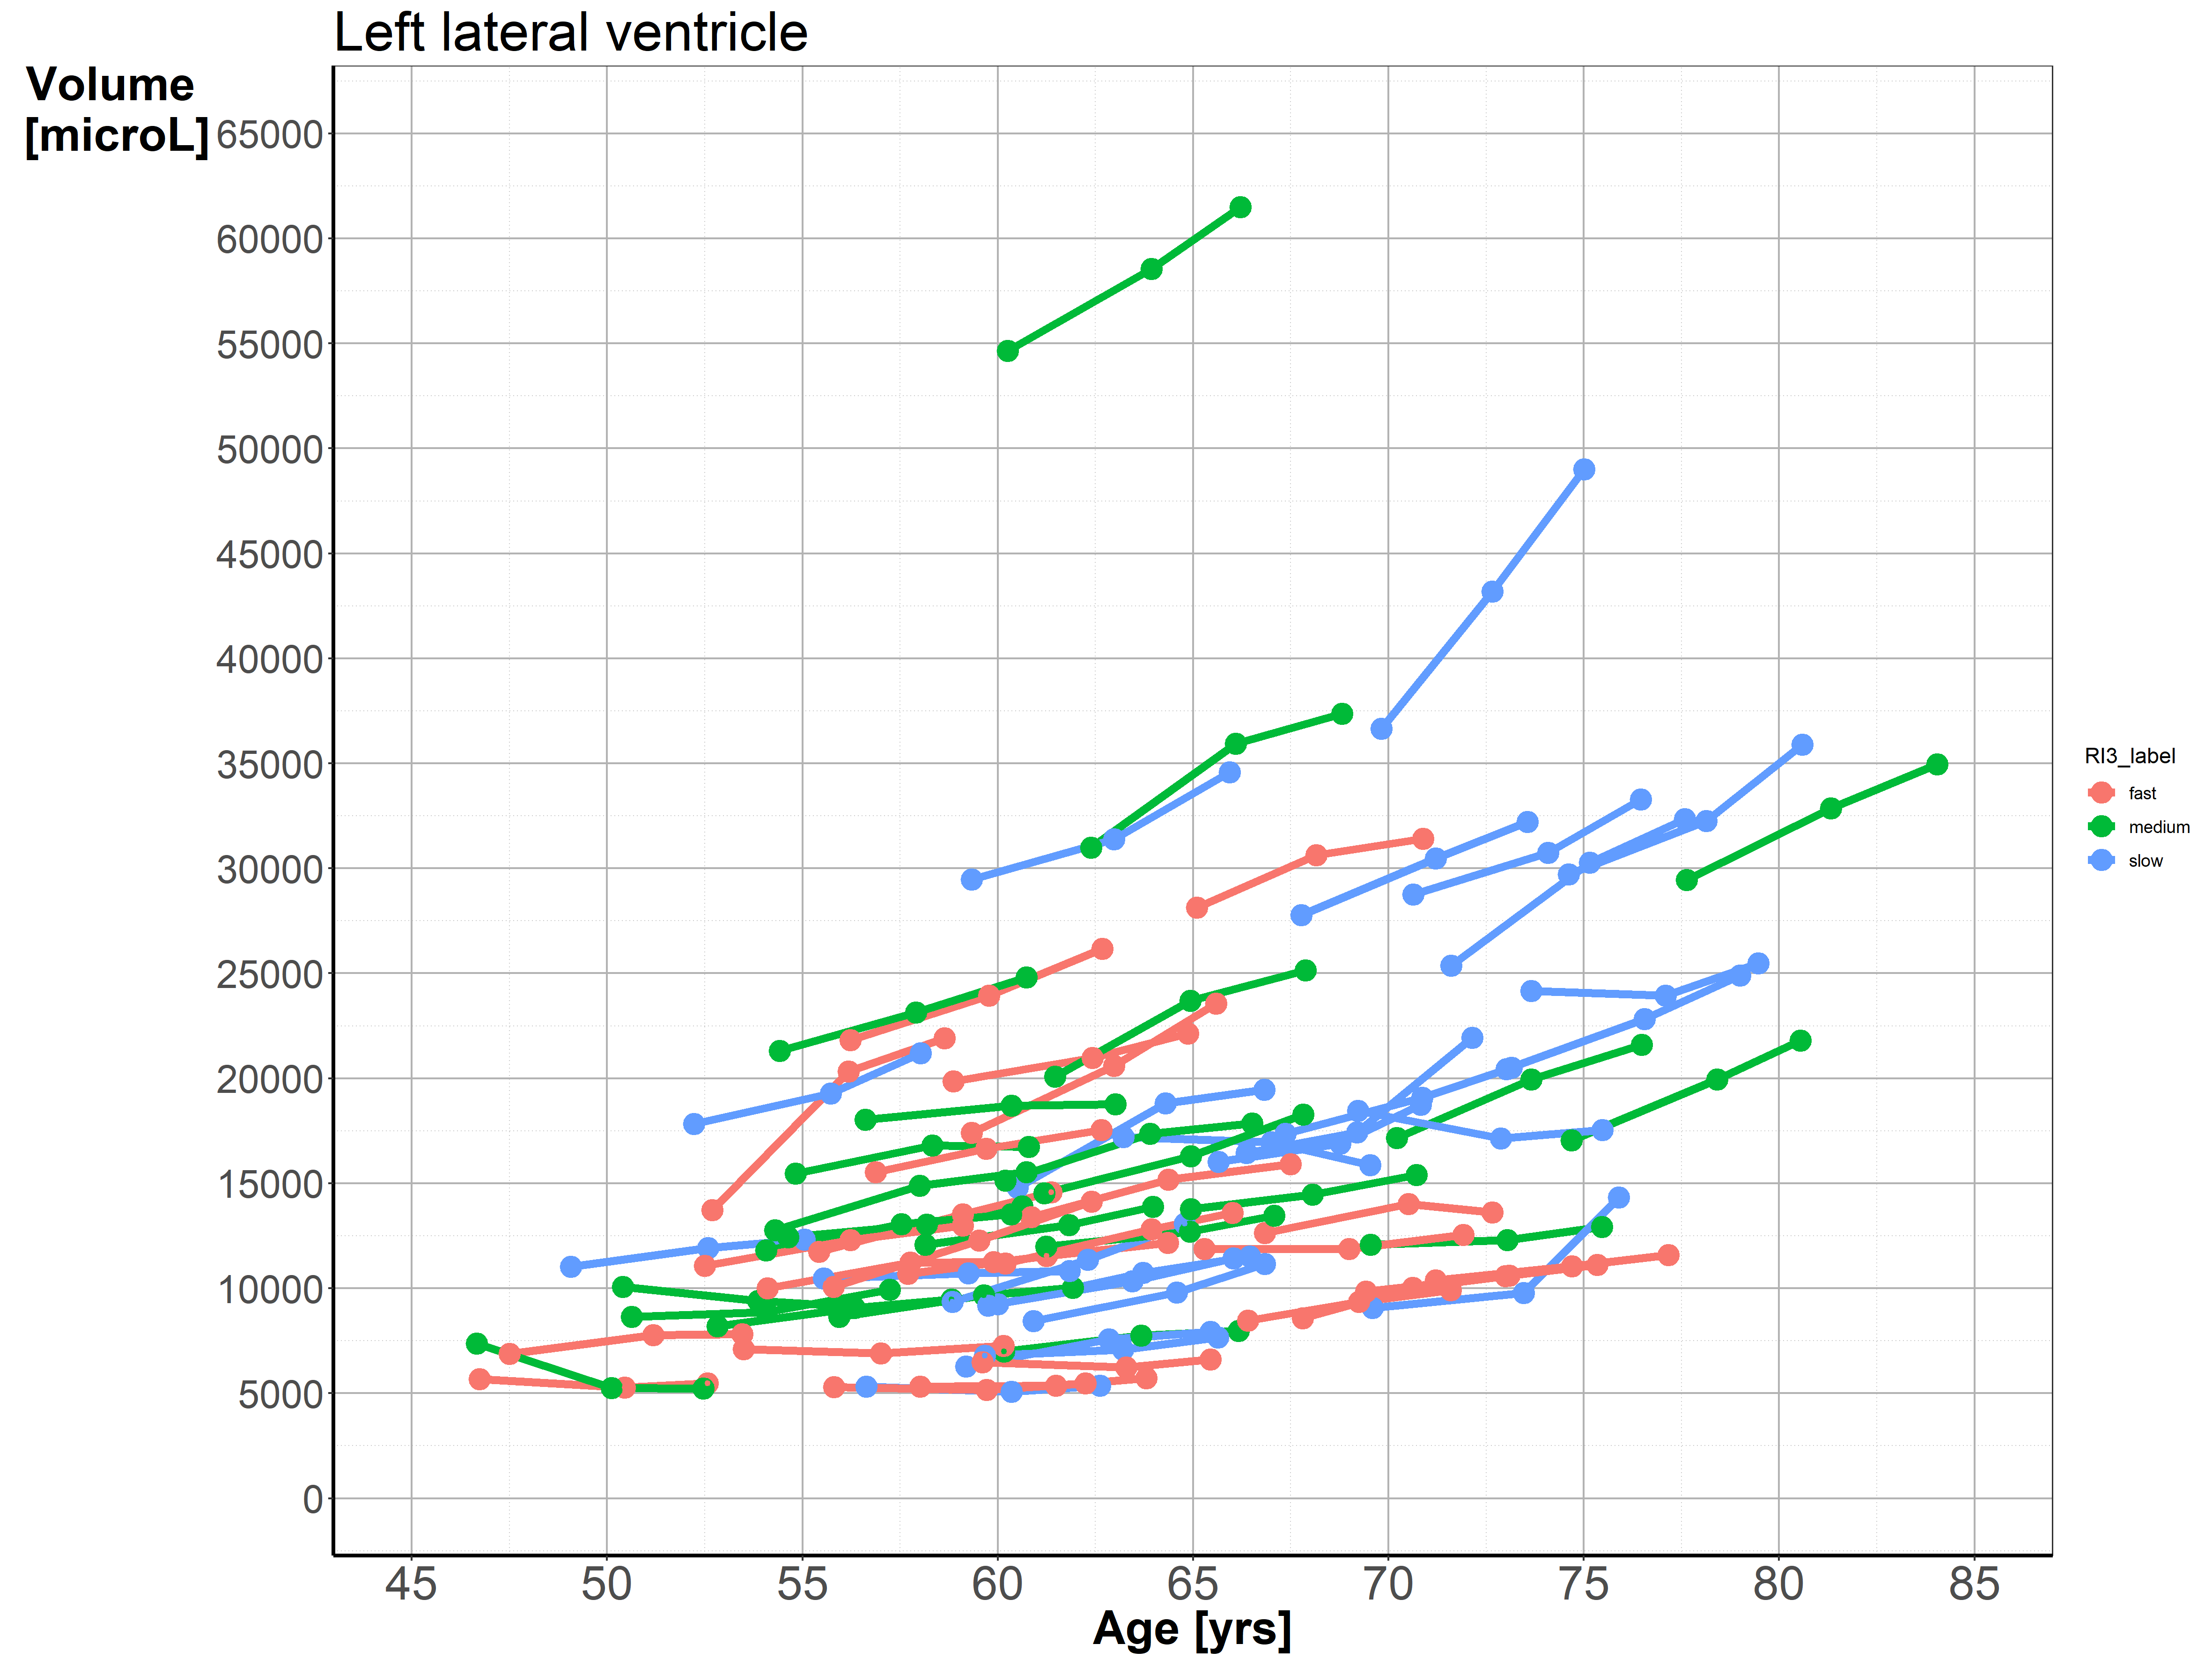

In [95]:
Image("../images/lvv_ri_rpy2_left_ventricle_by_RI3_label.png", width=900)

In [96]:
%R head(df.longR)

Subject                 Region Wave    Age   Volume
0      01  RightLateralVentricle    1  56.63   6855.2
1      01  RightLateralVentricle    2  60.35   6729.2
2      01  RightLateralVentricle    3  62.62   7233.2
3      02  RightLateralVentricle    1  49.07  10611.6
4      02  RightLateralVentricle    2  52.58  11774.8
5      02  RightLateralVentricle    3  55.05  12070.5

In [97]:
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()

pd_df_longR = r['df.longR']
pd_df_longR.head(4)

Subject                 Region Wave    Age   Volume
0      01  RightLateralVentricle    1  56.63   6855.2
1      01  RightLateralVentricle    2  60.35   6729.2
2      01  RightLateralVentricle    3  62.62   7233.2
3      02  RightLateralVentricle    1  49.07  10611.6

In [98]:
dfR = pd_df_longR.copy()
dfR['id'] = dfR['Subject']
dfR = dfR.drop(['Region', 'Subject'], axis=1)
dfR.head(4)

Wave    Age   Volume  id
0    1  56.63   6855.2  01
1    2  60.35   6729.2  01
2    3  62.62   7233.2  01
3    1  49.07  10611.6  02

In [99]:
dfmriR = dfmri.copy()
dfmriR['id'] = pd_df['id']
dfmriR['RI3_label'] = df_cat['RI3_label']
dfmriR = dfmriR.drop(['Sex','Age3','b1iL','b1iR','VdevL','VdevR','RI3','RI3_jitter','RI3_cat'], axis=1)
dfmriR.head(4)

RI3_label  id
0      slow   1
1      slow   2
2      slow   3
3      fast   4

In [100]:
di = pd.Series(dfmriR.RI3_label.values,index=dfmriR.id).to_dict()
di.items()

dict_items([(1, 'slow'), (2, 'slow'), (3, 'slow'), (4, 'fast'), (5, 'slow'), (6, 'slow'), (7, 'fast'), (8, 'medium'), (9, 'fast'), (10, 'medium'), (11, 'slow'), (12, 'medium'), (13, 'fast'), (14, 'medium'), (15, 'medium'), (16, 'medium'), (17, 'medium'), (18, 'slow'), (19, 'medium'), (20, 'medium'), (21, 'fast'), (22, 'fast'), (23, 'fast'), (24, 'fast'), (25, 'medium'), (26, 'slow'), (27, 'slow'), (28, 'fast'), (29, 'medium'), (30, 'medium'), (31, 'slow'), (32, 'slow'), (33, 'slow'), (34, 'slow'), (35, 'fast'), (36, 'fast'), (37, 'fast'), (38, 'medium'), (39, 'medium'), (40, 'medium'), (41, 'fast'), (42, 'fast'), (43, 'medium'), (44, 'medium'), (45, 'medium'), (46, 'fast'), (47, 'fast'), (48, 'slow'), (49, 'slow'), (50, 'slow'), (51, 'slow'), (52, 'slow'), (53, 'medium'), (54, 'fast'), (55, 'slow'), (56, 'slow'), (57, 'fast'), (58, 'slow'), (59, 'medium'), (60, 'fast'), (61, 'slow'), (62, 'medium'), (63, 'slow'), (64, 'slow'), (65, 'medium'), (66, 'fast'), (67, 'fast'), (68, 'fast'), (

In [101]:
dfR['Subject']=dfR['id']
dfR['id']=dfR['id'].astype('int32')
dfR['id'].replace(di, inplace=True)
dfR['RI3_label']=dfR['id'].astype('category')
dfR = dfR.drop(['id'], axis=1)
dfR.head()

Wave    Age   Volume Subject RI3_label
0    1  56.63   6855.2      01      slow
1    2  60.35   6729.2      01      slow
2    3  62.62   7233.2      01      slow
3    1  49.07  10611.6      02      slow
4    2  52.58  11774.8      02      slow

In [102]:
%%R -i dfR

# Right lateral ventricle

df <-  dfR

title.1.R <- "Right lateral ventricle"

mytitle <- title.1.R

g11 <- ggplot(data = df, aes(x = Age, y = Volume, group = Subject, colour = factor(RI3_label))) + geom_line(size=2)
g11 <- g11 + scale_colour_discrete(name  ="RI3_label") + geom_point(pch=19, size = 5)
myX <- scale_x_continuous(limits = c(45, 85), breaks = seq(45, 85, 5), name = "Age [yrs]")
myY <- scale_y_continuous(limits = c(500, 65000), breaks = seq(0, 65000, 5000), name = "Volume\n [microL]") 

g11 <- g11 + geom_point(size = 1.0) + theme_bw() + myX + myY
g11 <- g11 + labs(title = mytitle, fontsize = 32)
# Set title to twice the base font size
g11 <- g11 + theme(plot.title = element_text(size = rel(2.0)))
g11 <- g11 + theme(axis.line = element_line(size = 1, colour = "black", linetype = "solid"))
g11 <- g11 + theme(axis.text = element_text(size = rel(1.5)))
g11 <- g11 + theme(axis.title.y = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(axis.title.x = element_text(size = rel(1.8), angle = 0))
g11 <- g11 + theme(panel.grid.major = element_line(colour = "gray70"))
g11 <- g11 + theme(panel.grid.minor = element_line(colour = "gray80", linetype = "dotted"))
g11 <- g11 + theme(plot.background = element_rect(fill = "white"))

g11 <- g11 + theme(axis.text.x=element_text(size=24), axis.title.x=element_text(size=24,face="bold"))
g11 <- g11 + theme(axis.text.y=element_text(size=20), axis.title.y=element_text(size=24,face="bold"))
g11 <- g11 + theme(plot.title = element_text(size=28))

ggsave("../images/lvv_ri_rpy2_right_ventricle_by_RI3_label.pdf", width = 40, height = 30, units = "cm")
ggsave("../images/lvv_ri_rpy2_right_ventricle_by_RI3_label.png", width = 40, height = 30, units = "cm")

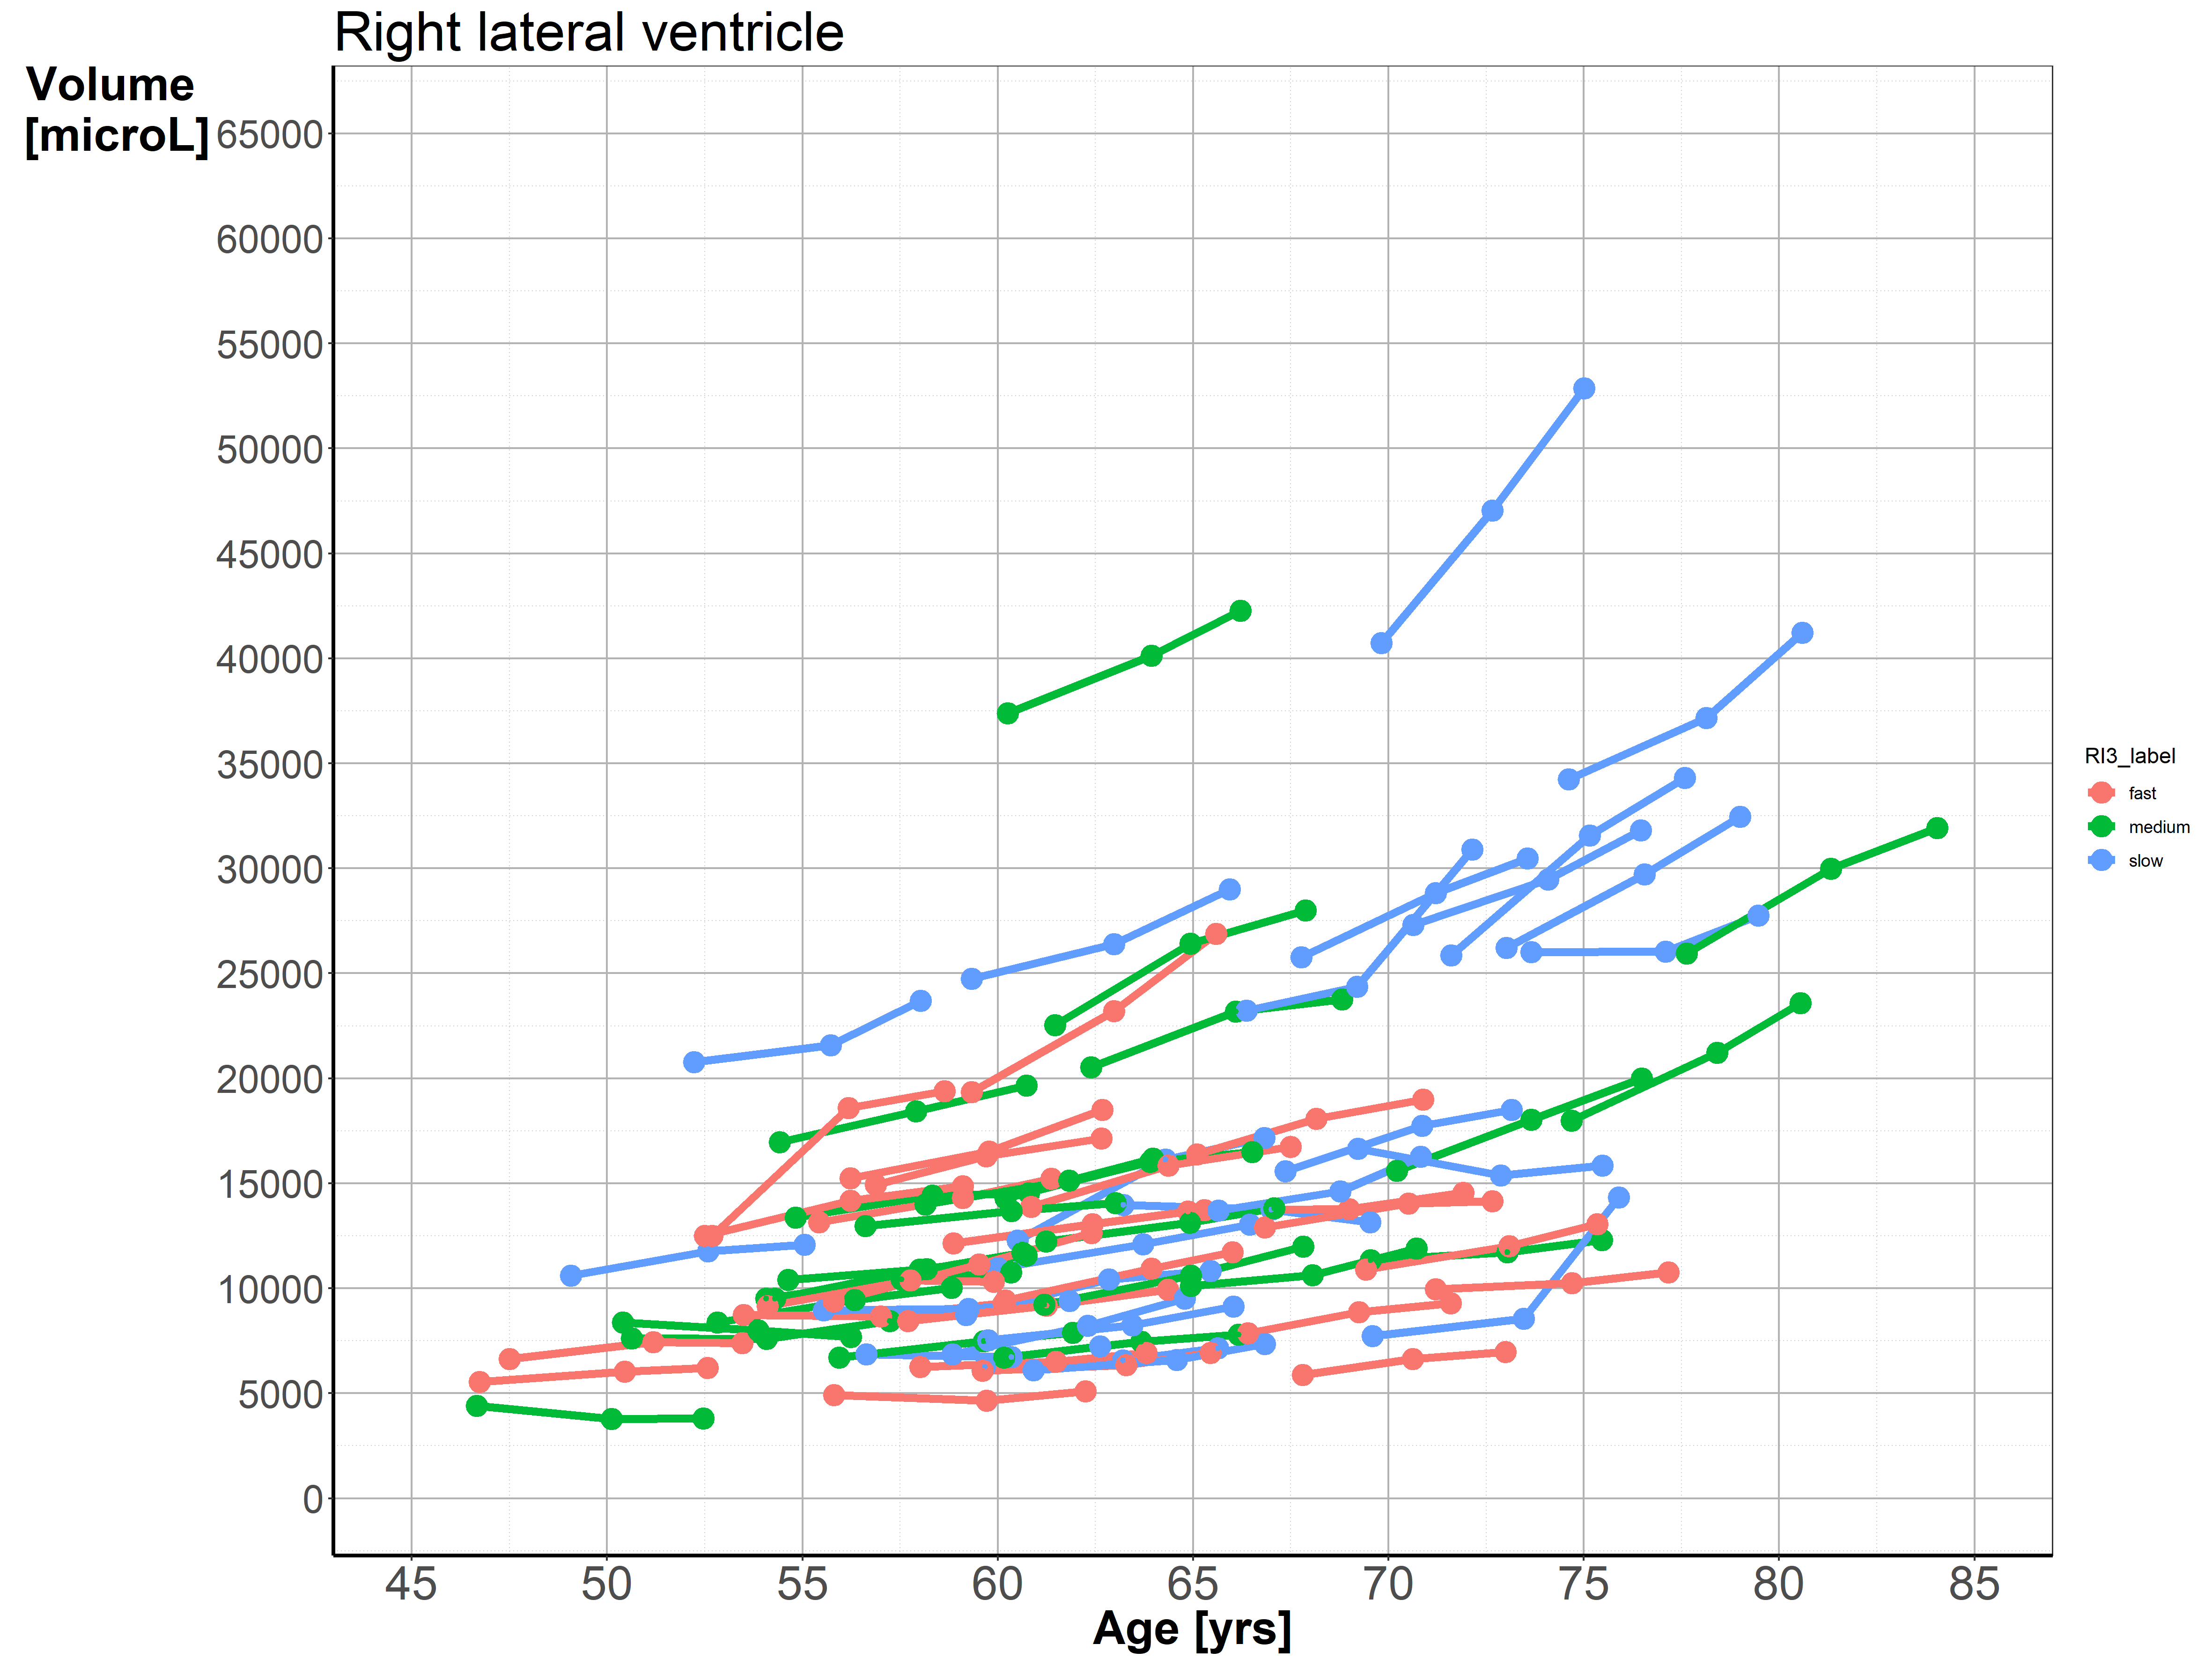

In [103]:
Image("../images/lvv_ri_rpy2_right_ventricle_by_RI3_label.png", width=900)